In [2]:
# Copied from 250212_SigClipKT_EmissionThreshold.ipynb to switch back to the non-FG sightline object (potentially with modifications)

from multiprocessing import Pool
import multiprocessing as mp
import os
os.environ['OMP_NUM_THREADS'] = "1"

import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib 

from astropy.io import fits
from astropy.table import Table, join
from astropy.wcs import WCS
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import spearmanr

from dustmaps.vergely2022 import Vergely2022Query
from dustmaps.edenhofer2023 import Edenhofer2023Query

import pickle 
import sys
import os
import tqdm
import datetime

import emcee
import corner

import h5py
import multiprocessing as mp

from spectral_cube import SpectralCube

from scipy.signal import correlate, correlation_lags


data_dir = '/uufs/chpc.utah.edu/common/home/astro/zasowski/mcbride/'

/uufs/astro.utah.edu/common/home/u1371365/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
import logging 

logger = logging.getLogger(__name__)


def logger_setup(log_file, level = logging.DEBUG):
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    fhandler = logging.FileHandler(log_file, mode='w')    
    fhandler.setLevel(logging.INFO)
    fformatter = logging.Formatter('%(asctime)s - %(name)s - %(message)s')
    fhandler.setFormatter(fformatter)

    shandler = logging.StreamHandler()
    shandler.setLevel(logging.INFO)
    sformatter = logging.Formatter('%(asctime)s - %(message)s')
    shandler.setFormatter(sformatter)
    
    logger.addHandler(fhandler)

logger_setup('LOGS/a_log_{}.log'.format(logger.name))


In [4]:
from astropy.stats import sigma_clip

In [5]:
import globalvars
dust_data = globalvars.DustData()

map_fname = '/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/edenhofer_out.h5'

with h5py.File(map_fname, 'r') as f:
    edenhofer = np.array(f['data'])
    dust_data.intake_map(edenhofer)

/tmp/ipykernel_4137743/1915891845.py:7: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  edenhofer = np.array(f['data'])


In [6]:
dust_extent = (dust_data.l.min(), dust_data.l.max(), dust_data.b.min(), dust_data.b.max())


In [7]:
from specfns import get_wavs, resample_interp, dopplershift, lambda0, sigma0
from filehandling import get_ca_res, get_madgics_res, get_medres
from spacefns_v2 import select_stars, find_nearest, find_radius, differentialAmplitude
from MCMCfns import logprob_2
from sightline import Sightline
import time

In [8]:
# CA_meta = Table(fits.open(data_dir + '/data/230420_CAResiduals/CA_meta.fits')[1].data)
CA_meta  = Table(fits.open('../240723_EmissionMaps/CA_meta_LSR_uncerts.fits')[1].data)

CAresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230420_CAResiduals/'
CAMADGICSresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230829_MADGICSResiduals/'
# starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
# starhorse = Table.read(starhorsepath, hdu = 1)
# starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

# CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

CA_meta_full = CA_meta.copy()

with open('/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/goodbad.pickle', mode = 'rb') as f:
    goodbad = pickle.load(f)
    # CA_meta = CA_meta[goodbad]

# added 02.01
data_criteria = (((CA_meta['SNR'] > 80) & (CA_meta['TEFF'] > 5000)) | (CA_meta['SNR'] > 150)) & (CA_meta['ASPCAP_CHI2_1'] > 1) & (CA_meta['ASPCAP_CHI2_1'] < 5)
print(np.sum(data_criteria))
CA_meta= CA_meta[data_criteria]

1009


In [9]:
# added 2025 January 28
CA_meta = CA_meta[(CA_meta['DIST'] > 350) & (CA_meta['DIST'] < 600)]

In [10]:
# sigma clip the DIB_EQW

# line = lambda x, m: m*x + 0
# from scipy.optimize import curve_fit
# popt, pcov = curve_fit(line, CA_meta['DIST'], CA_meta['DIB_EQW'], nan_policy = 'omit')

# sigclip = sigma_clip(CA_meta['DIB_EQW'] - line(CA_meta['DIST'], *popt), sigma = 1.5, maxiters = 5)

# CA_meta = CA_meta[~sigclip.mask]

In [11]:
### Load in the emission data in workable cubes using spectral_cube

fname_hi4pi = '/uufs/chpc.utah.edu/common/home/astro/zasowski/catalogs/HI4PI_CAR.fits'
hdul_hi4pi = fits.open(fname_hi4pi)
header_hi4pi = hdul_hi4pi[0].header[:]
hdul_hi4pi[0].header['CDELT3'] = hdul_hi4pi[0].header['CDELT3'] / 1e3
hdul_hi4pi[0].header['CRVAL3'] = hdul_hi4pi[0].header['CRVAL3'] / 1e3
hdul_hi4pi[0].header['CUNIT3'] = 'km/s'
hdul_hi4pi[0].header['COMMENT'] = 'Converted to km/s 08.23.24 in 240723_EmissionMaps/240922_HIMapsExplore.ipynb'

fname_CO = '/uufs/chpc.utah.edu/common/home/astro/zasowski/catalogs/DHT21_Taurus_interp.fits'
hdul_CO = fits.open(fname_CO)
header_CO =hdul_CO[0].header[:]
hdul_CO[0].header['CTYPE1'] = 'VRAD'
hdul_CO[0].header['CUNIT1'] = 'km/s'
hdul_CO[0].header['COMMENT'] = 'Edited 08.23.24 in 240723_EmissionMaps/240922_HIMapsExplore.ipynb'

cube_hi4pi = SpectralCube(data = hdul_hi4pi[0].data, wcs = WCS(hdul_hi4pi[0].header), header = hdul_hi4pi[0].header)
cube_CO = SpectralCube(data = hdul_CO[0].data, wcs = WCS(hdul_CO[0].header), header = hdul_CO[0].header)

velo_hi4pi, b_hi4pi, l_hi4pi = cube_hi4pi.world[0, :, :]
velo_CO, b_CO, l_CO = cube_CO.world[0, :, :]

dust_extent = (dust_data.l.min(), dust_data.l.max(), dust_data.b.min(), dust_data.b.max())
cube_HI_CA = cube_hi4pi.subcube(xlo = dust_extent[0]*u.deg, xhi = dust_extent[1]*u.deg, ylo = dust_extent[2]*u.deg, yhi = dust_extent[3]*u.deg).spectral_slab(-15 * u.km/u.s, 10 * u.km/u.s)
cube_CO_CA = cube_CO.subcube(xlo = dust_extent[0]*u.deg, xhi = dust_extent[1]*u.deg, ylo = dust_extent[2]*u.deg, yhi = dust_extent[3]*u.deg).spectral_slab(-15 * u.km/u.s, 10 * u.km/u.s)

CO_extent = cube_CO_CA.world_extrema.value.flatten()
CO_extent = CO_extent[[1, 0, 2, 3]]

In [12]:
b_CO, l_CO = cube_CO_CA.world[0, :, :][1:]
b_CO, l_CO = b_CO[:, 0], l_CO[0, :]
b_HI, l_HI = cube_HI_CA.world[0, :, :][1:]
b_HI, l_HI = b_HI[:, 0], l_HI[0, :]

CO_star_indices = np.array([[ np.argmin((CA_meta['GLAT'][i] - b_CO.value)**2), np.argmin((CA_meta['GLON'][i] - l_CO.value)**2)] for i in range(len(CA_meta))])
HI_star_indices = np.array([[ np.argmin((CA_meta['GLAT'][i] - b_HI.value)**2), np.argmin((CA_meta['GLON'][i] - l_HI.value)**2)] for i in range(len(CA_meta))])

/tmp/ipykernel_4137743/2493111877.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  correlation_image[i, j] = correlate(cube_CO_CA.unmasked_data[:, i, j] / np.nansum(np.abs(cube_CO_CA.unmasked_data[:, i, j])), reference_point / np.nansum(np.abs(reference_point)))[zpoint]


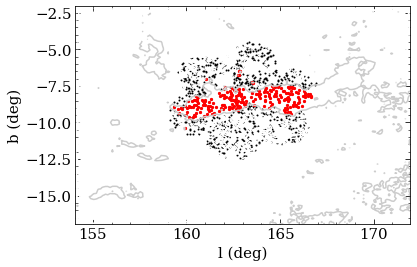

In [13]:
co_i, co_j = np.argmin(np.abs(l_CO.value -167.4)), np.argmin(np.abs(b_CO.value + 8.3))
reference_point = cube_CO_CA.unmasked_data[:, co_j, co_i]
corr_lags = correlation_lags(cube_CO_CA.shape[0], cube_CO_CA.shape[0])

zpoint = corr_lags == 0
correlation_image = np.zeros((cube_CO_CA.shape[1], cube_CO_CA.shape[2]))
for i in range(cube_CO_CA.shape[1]):
    for j in range(cube_CO_CA.shape[2]):
        correlation_image[i, j] = correlate(cube_CO_CA.unmasked_data[:, i, j] / np.nansum(np.abs(cube_CO_CA.unmasked_data[:, i, j])), reference_point / np.nansum(np.abs(reference_point)))[zpoint]

fig, ax = plt.subplots()
cont = ax.contour(correlation_image, origin = 'lower', cmap = 'binary', extent = CO_extent, vmin = 0.02, vmax = 0.07 , levels = (0, 0.03))# vmin = 0, vmax =200)
# im = ax.imshow(correlation_image, origin = 'lower', cmap = 'binary', extent = CO_extent)

stars_CO_correlation = correlation_image[CO_star_indices[:, 0], CO_star_indices[:, 1]]
# this is the correct order of indices; verify by plotting the stars colored by correlation value

ax.scatter(CA_meta['GLON'], CA_meta['GLAT'], c = 'k', s = 1)
ax.scatter(CA_meta['GLON'][stars_CO_correlation > 0.03], CA_meta['GLAT'][stars_CO_correlation > 0.03], c = 'r', s = 5)

ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
plt.show()

In [14]:
print(dust_extent, CO_extent)

(154.0, 172.0, -17.0, 1.0) [172. 154. -17.  -2.]


In [15]:
print(len(CA_meta), np.sum(stars_CO_correlation > 0.03))
CA_meta = CA_meta[stars_CO_correlation > 0.03]

980 238


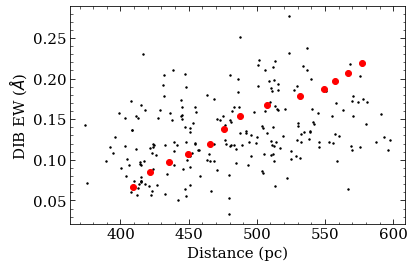

In [16]:
from star_selection_metrics import selectOnEW
selection = selectOnEW(CA_meta, vector = (0.05, 0.05))
fig, ax = plt.subplots()
ax.scatter(CA_meta['DIST'], CA_meta['DIB_EQW'], c= 'k', s =2)
ax.scatter(CA_meta['DIST'][selection], CA_meta['DIB_EQW'][selection], c = 'r')
# fig.savefig('../figures/selection_plot.png', bbox_inches = 'tight')
ax.set_xlabel('Distance (pc)')
ax.set_ylabel('DIB EW ($\AA$)')
plt.show()


In [17]:
lambda0 = 15272.42
from specfns import get_wavs

wavs = get_wavs()
window = (wavs > lambda0 -10) & (wavs < lambda0 + 10)
wavs_window = wavs[window]

In [18]:
ds = 1 # x downsampled
rad = 2

sample_dim_l = np.linspace(159, 167, int(8 / (ds * rad)))
sample_dim_b = np.linspace(-12.5 , -4.5, int(8 / (ds * rad)))
sample_grid_l, sample_grid_b = np.meshgrid(sample_dim_l, sample_dim_b)
grid_map_inds = np.array([find_nearest(sample_grid_l.flatten()[i], sample_grid_b.flatten()[i]) for i in range(len(sample_grid_l.flatten()))]).T
grid_map = np.nansum(np.copy(edenhofer[grid_map_inds[1], grid_map_inds[0], :]).reshape(*sample_grid_l.shape, -1), axis = 2)
grid_Nstar = np.array([np.nansum((np.abs((sample_grid_l.flatten()[i] - CA_meta['GLON'])) <= rad) & 
            (np.abs((sample_grid_b.flatten()[i] - CA_meta['GLAT'])) <= rad)) for i in range(len(sample_grid_l.flatten()))]).reshape(*sample_grid_l.shape)

filament_l = (159, 169)
filament_b = (-10, -6)

N_min = 25
radius_min = np.zeros(sample_grid_l.shape)
mgrid = np.mgrid[0:len(sample_dim_l), 0:len(sample_dim_b)]
for i in mgrid[0].flatten():
    for j in mgrid[1].flatten():
        radius_min[i, j] = find_radius(sample_grid_l[i, j], sample_grid_b[i, j], N_min, CA_meta)
        radius_min[i, j] = np.max([radius_min[i, j], rad])

radius_max = 0.4
print(np.nansum(radius_min < radius_max))


crit_filament = ((sample_grid_l > filament_l[0]) & (sample_grid_l < filament_l[1]) & 
                 (sample_grid_b > filament_b[0]) & (sample_grid_b < filament_b[1]) &
                 (grid_map > 2.2) & (radius_min < 0.5)) #(grid_Nstar > 5) & (grid_Nstar <= 10))

crit_background =  (((sample_grid_l <= filament_l[0]) | (sample_grid_l >= filament_l[1]) |
                 (sample_grid_b <= filament_b[0]) | (sample_grid_b >= filament_b[1])) &
                 (grid_map <= 1.5) & (radius_min < radius_max)) #(grid_Nstar > 5) & (grid_Nstar <= 10))

# crit_coverage = (np.sum() => 1 & )

N_filament = np.sum(crit_filament)
N_background = np.sum(crit_background)
print(np.sum(crit_filament))
print(np.sum(crit_background))
l_fil, b_fil, AV_fil = (sample_grid_l[crit_filament].flatten(), sample_grid_b[crit_filament].flatten(),
                        grid_map[crit_filament].flatten())
l_off, b_off, AV_off = (sample_grid_l[crit_background].flatten(), sample_grid_b[crit_background].flatten(),
                        grid_map[crit_background].flatten())

l_sample, b_sample, AV_sample = (np.concatenate([l_fil, l_off]), np.concatenate([b_fil, b_off]),
                                  np.concatenate([AV_fil, AV_off]))
radius_min_fil = radius_min[crit_filament].flatten()
radius_min_off = radius_min[crit_background].flatten()
radius_sample = np.concatenate([radius_min_fil, radius_min_off])

# selected_inds = []
# for i in range(len(l_sample)):
#     l_center, b_center = l_sample[i], b_sample[i]
#     rad_i = radius_sample[i]
#     selection = select_stars(CA_meta, l_center, b_center, radius = rad_i)
#     # print(len(selection))
#     selected_inds.append(selection)

0
0
0


In [19]:
selected_inds_old= []
# N_min_vals = [15, 20, 30, 40]
N_min_vals = [25]
l_center, b_center = 165,-8.5
for N_min in N_min_vals:
    # N_min = 25
    radius_min = 0
    mgrid = np.mgrid[0:len(sample_dim_l), 0:len(sample_dim_b)]
    rad = find_radius(l_center, b_center, N_min, CA_meta)
    rad_sel = np.max([radius_min, rad])
    selection = select_stars(CA_meta, l_center, b_center, radius = rad_sel)
    # print(len(selection))
    selected_inds_old.append(selection)

In [20]:
CA_meta_ = CA_meta.copy()

CA_meta['GLON_True'] = CA_meta['GLON']
CA_meta['GLAT_True'] = CA_meta['GLAT']

coordinates_save = CA_meta[selected_inds_old[0]]['GLON', 'GLAT']
print(len(coordinates_save))

25


In [21]:
selected_inds = []
# N_min_val = 25
np.random.seed(42)
vec_size = (0.01, 0.05)
for i in range(2):
    vec = vec_size[i]
    bootstrap_selection = selectOnEW(CA_meta, vector = (vec, vec))
    selected_inds.append(bootstrap_selection)

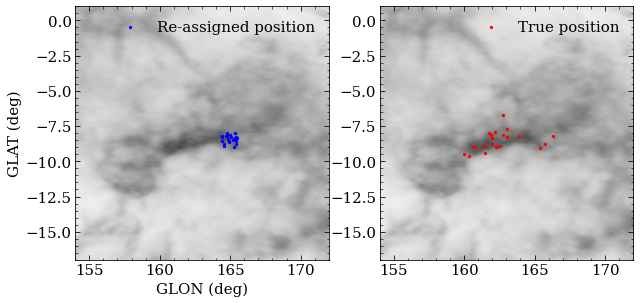

In [22]:
sig, axs = plt.subplots(nrows = 1, ncols = 2,   figsize = (10, 5))
ax = axs[0]
ax.imshow(np.nansum(dust_data.dustmap, axis = 2), extent=dust_extent, origin='lower', cmap = 'binary', vmin = 0, vmax = 5)
ax.scatter(coordinates_save['GLON'], coordinates_save['GLAT'], c = 'b', s = 5, label = 'Re-assigned position')
ax.set_xlabel('GLON (deg)')
ax.set_ylabel('GLAT (deg)')
ax.legend()

ax = axs[1]
ax.imshow(np.nansum(dust_data.dustmap, axis = 2), extent=dust_extent, origin='lower', cmap = 'binary', vmin = 0, vmax = 5)
ax.scatter(CA_meta['GLON_True'][selected_inds[0]], CA_meta['GLAT_True'][selected_inds[0]], c = 'r', s = 5, label = 'True position')
ax.legend()
fig.set_facecolor('white')
plt.show()

In [23]:
dibfn = lambda x, mu, sigma, a: 1-a * np.exp(-0.5 * (x - mu)**2 / sigma**2)
def sigma_clip_mask(y, x = wavs, k = 2.5):
    y_over_gauss = None

    try:
        gaussfit = curve_fit(dibfn, x[window], y[window].filled(np.nan), p0 = (15272, 1.2, 0.05), bounds = ([15269, 0.5, 0], [15275, 2, 0.15]), check_finite = False, nan_policy = 'omit')

    except:
        # gaussfit = ((15272, 1.2, 0.05),())
        print('fail')
        return None, None
    #     y_over_gauss = None
    #     gaussfit = ((15272, 1.2, 0.05),())
    #     # fit = dibfn(x, 15272.42, 1.2, 0.05)
    #     # y_over_gauss = y / fit
    #     print('POOR GAUSS FIT IN SIGMA CLIP')
    y_over_gauss = y / dibfn(x, *gaussfit[0])

    med = np.nanmedian(y_over_gauss[window])
    stdev = np.std(y_over_gauss[window], ddof = 1)
    mask = np.abs(y_over_gauss - med) > k * stdev
    mask = mask + np.roll(mask, -1) + np.roll(mask, -1)
    mask = mask.astype(bool)
    return mask, stdev

def sigmaClip(y, yerr,k=2.5):
    clip = True
    clip_iters = 0
    std = np.nanstd(y[window], ddof = 1)
    mask = np.zeros(y.shape).astype(bool)
    clip_success = True

    while clip:
        clip_mask, std_clipped = sigma_clip_mask(np.ma.array(y, mask = mask.copy()), k = k)
        if clip_mask is None:
            clip_success = False
            return mask, clip_success
        clip_mask = clip_mask.filled(False)

        if std - std_clipped  < 1e-4:
            clip = False


        else:
            clip_iters += 1
            std = std_clipped
            mask = mask + clip_mask

    return mask, clip_success

In [24]:
# dataPath = '/uufs/chpc.utah.edu/common/home/astro/zasowski/mcbride/data/DHT21_Taurus_interp.fits'
# hdulCO = fits.open(dataPath)

# headerCO = hdulCO[0].header
# dataCO = hdulCO[0].data
# wcsCO = WCS(headerCO)

# glon = headerCO['CRVAL2'] + headerCO['CDELT2'] * (np.arange(0, headerCO['NAXIS2'])- headerCO['CRPIX2'])
# glat = headerCO['CRVAL3'] + headerCO['CDELT3'] * (np.arange(0, headerCO['NAXIS3'])- headerCO['CRPIX3'])
# rvel = headerCO['CRVAL1'] + headerCO['CDELT1'] * (np.arange(0, headerCO['NAXIS1'])- headerCO['CRPIX1'])

# l, b, v = np.meshgrid(glon, glat, rvel)
# coord = SkyCoord(l * u.deg, b  * u.deg, radial_velocity = v * u.km/u.s, pm_l_cosb = 0 * u.deg/u.s,
#                   pm_b = 0 * u.deg / u.s, distance = 500 * u.pc, frame = 'galacticlsr')

# coord_icrs = coord.transform_to('icrs')

# def get_CO_profile(l, b):
#     coord_sel = SkyCoord(l = l * u.deg, b = b * u.deg, frame = 'galactic')
#     pix_ind_l, pix_ind_b = wcsCO.world_to_pixel(0 * u.km/u.s, coord_sel)[1:]
#     CO_profile = dataCO.T[:, int(pix_ind_l), int(pix_ind_b)]
#     rvel = coord_icrs.T.radial_velocity[:, int(pix_ind_l), int(pix_ind_b)]
#     return CO_profile, rvel
# profile, rvel = get_CO_profile(165, -7)

# plt.plot(rvel, profile)

In [25]:
def generateClippedResidual(aspcap, medres, apstar, rv, k = 3):
    spectrum = aspcap[1].data
    model = aspcap[3].data
    err = aspcap[2].data
    bitmask = apstar[3].data[0, :]

    if medres[1].data is None:
        medres_model = np.ones(spectrum.shape)
        medres_err =np.zeros(spectrum.shape)
    else:
        medres_model = np.array(medres[1].data)
        medres_err = np.array(medres[3].data)



    mask_digits = [0, 1, 2, 9, 12, 13] # 0 BADPIX, 1 CRPIX, 2 SATPIX, 9 PERSIST_HIGH, 12 SIG_SKYLINE, 13 SIG_TELLURIC
    mask = np.zeros(bitmask.shape)
    for digit in mask_digits:
        mask = mask + np.bitwise_and(bitmask.astype(int), 2**digit) 

    mask = mask.astype(bool)
    res_corr = spectrum / model / medres_model
    # print('res corr shape', res_corr.shape)
    uncertainty_corr = np.sqrt(err**2) #+ medres_err**2)

    sky_residuals = [(15268.1, 1),(15274.1, 1),(15275.9, 1)]
    manual_masks = np.zeros(len(wavs))
    for sky in sky_residuals:
        wl = sky[0]
        manual_masks[np.argmin(np.abs(wavs - wl))] = True
    manual_masks = manual_masks + np.roll(manual_masks, -1) + np.roll(manual_masks, 1)

    # mask_sigmaclip = np.zeros(len(wavs))


    maskSigClip, clip_success = sigmaClip(res_corr, uncertainty_corr, k = k)

    mask = mask + maskSigClip
    mask = mask.astype(bool)

    res_corr_ma = np.ma.array(res_corr, mask = mask)
    res_corr_filled = res_corr_ma.filled(np.nan)

    res_corr_resamp = resample_interp(res_corr_filled, rv)
    uncertainty_corr_resamp = resample_interp(uncertainty_corr, rv)

    sky_residuals = [(15268.1, 1),(15274.1, 1),(15275.9, 1)]
    manual_masks = np.zeros(len(wavs))
    for sky in sky_residuals:
        wl = sky[0]
        manual_masks[np.argmin(np.abs(wavs - wl))] = True
    manual_masks = manual_masks + np.roll(manual_masks, -1) + np.roll(manual_masks, 1)


    res_corr_resamp = np.ma.array(res_corr_resamp, mask = manual_masks)
    res_corr_resamp = res_corr_resamp.filled(np.nan)


    return res_corr_resamp, uncertainty_corr_resamp#, clip_success

In [26]:
from spacefns_v2 import dAV_dd_array
from residual_process import reprocess
from filehandling import getASPCAP, getapStar

class Sightline_Modernized:
    ### Container object for stars, sightline dAV_dd, velocity, and spaxel assignment.
    def __init__(self, stars, bins = None, **kwargs):
        self.stars = stars
        dist = self.stars['DIST']

        if bins is not None:
            h = np.histogram(dist, bins)[0]
            self.bins = np.insert(bins[1:][h != 0], 0, bins[0])
            self.bin_inds = np.digitize(dist, bins)
        else:
            self.make_bins()
            self.bin_inds = np.digitize(dist, self.bins)  
        self.rvelo = np.zeros(len(self.bins) - 1)
        self.get_DIBs(**kwargs)
        self.init_signals = self.model_signals(self.rvelo, self.dAVdd)
        self.ndim = len(self.voxel_dAVdd)
        self.nsig = len(self.stars)
        
    def make_bins(self, binsep = 10, dmin = 0):
        ### Assigns stars to distance bins if bins are not already supplied.
        dist = self.stars['DIST']
        bins = np.sort(np.insert(np.delete(dist, np.where(dist <= dmin)[0]), 0, dmin))

        i = 0
        while i >= 0:
            try:
                next_bin = np.min(bins[bins > bins[i]])
            except:
                print('broke:')
                print(bins[bins > bins[i]])
                print(len(self.stars))

            bins[i+1] = np.max([next_bin, bins[i] + binsep]) + 0.01
            if bins[i+1] >= np.max(dist):
                bins = bins[:i+2]
                i = -np.inf
            i = i+1
        
        self.bins = bins
            
    def get_DIBs(self, MADGICS = False, alternative_data_processing = None, **kwargs):
        signals = np.zeros((len(self.stars), len(wavs_window)))
        signal_errs = np.zeros((len(self.stars), len(wavs_window)))
        dAVdd = np.zeros((len(self.stars), len(self.bins)-1))
        dAVdd_all = np.zeros((len(self.stars), len(self.bins)-1))
        dAVdd_mask =np.zeros((len(self.stars), len(self.bins)-1)).astype(bool)

        if alternative_data_processing is not None:
            # needs to take aspcap, medres, apstar, rv as arguments
            for i in range(len(self.stars)):
                star = self.stars[i]
                star_rv = star['VHELIO_AVG']
                aspcap = fits.open(getASPCAP(star))
                apstar = fits.open(getapStar(aspcap))
                medres = fits.open(get_medres(star['TEFF'], star['LOGG'], star['M_H']))
                sig, err = alternative_data_processing(aspcap, medres, apstar, star_rv)
                signals[i, :], signal_errs[i, :] = sig[window], err[window]

               
                l, b = star['GLON'], star['GLAT']
                dAVdd[i], dAVdd_all[i], dAVdd_mask[i] = dAV_dd_array(l, b, self.bins, star['DIST'], **kwargs)
        
        else:
            if MADGICS:
                signals_aspcap = np.zeros((len(self.stars), len(wavs_window)))
                signal_errs_aspcap = np.zeros((len(self.stars), len(wavs_window)))

            for i in range(len(self.stars)):
                star = self.stars[i]
                star_rv = star['VHELIO_AVG']
                res_hdul = fits.open(get_ca_res(star['FILE']))
                signals[i, :] = res_hdul[1].data[window]
                signal_errs[i, :] = res_hdul[2].data[window]
                reprocess_uncertainty = True
                if reprocess_uncertainty:
                    signal_errs[i, :] = self.reprocess_errs(res_hdul, star['VHELIO_AVG'])[window]
                reprocess_residual = True
                if reprocess_residual:
                    res_repr, err_repr = reprocess(res_hdul, star['VHELIO_AVG'])
                    signals[i, :] = res_repr[window]
                    signal_errs[i, :] = err_repr[window]
                l, b = star['GLON'], star['GLAT']
                dAVdd[i], dAVdd_all[i], dAVdd_mask[i] = dAV_dd_array(l, b, self.bins, star['DIST'], **kwargs)

                if MADGICS:
                    signals_aspcap[i, :] = np.copy(signals[i, :])
                    signal_errs_aspcap[i, :] = np.copy(signal_errs[i, :])
                    res_hdul_m = fits.open(get_madgics_res(star['FILE']))
                    signals[i, :] = res_hdul_m[1].data[0, 125:][window]



        self.signals = signals
        self.signal_errs = signal_errs
        self.dAVdd = dAVdd
        self.voxel_dAVdd = np.nanmedian(dAVdd_all, axis = 0)
        self.voxel_dAVdd_std = np.nanstd(dAVdd_all, axis = 0, ddof = 1)
        self.dAVdd_mask = dAVdd_mask.astype(bool)
        # self.dAVdd_v = dAVdd_v
        if MADGICS:
            self.signals_aspcap = signals_aspcap
            self.signal_errs_aspcap = signal_errs_aspcap

    def model_signals(self, rvelo, dAVdd = None, binsep = None):
        if dAVdd is None:
            dAVdd = self.dAVdd
        if binsep is None:
            binsep = self.bins[1:]-self.bins[:-1]
        # print('dAVdd shape: ', dAVdd.shape)
        # dAVdd[self.dAVdd_mask] = 0
        signals = np.zeros((len(self.stars), len(wavs_window)))
        peak_wavelength = dopplershift(rvelo)
        wavs_grid = np.tile(wavs_window, (len(self.bins) - 1, 1))
        voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
        amp = differentialAmplitude(dAVdd, binsep)

        def single_signal(amp, bindex):
            amp[bindex :] = 0 # THIS MIGHT NEED TO BE -1

            voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
            summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
            # continuum = lambda x, m, b : m * (x - lambda0) + b
            # cont = continuum(wavs_window, 0, b)
            return summed_DIB  + 1


        for i in range(len(self.stars)):
            star = self.stars[i]
            dAVdd_star = dAVdd[i, :]
            # amp = Differential_Amplitude(dAVdd_star, self.bins[1:]-self.bins[:-1])
            amp = differentialAmplitude(dAVdd_star, 1)

            bin_index = self.bin_inds[i]
            # signals[i, :] = single_signal(bin_index)
            signals[i, :] = single_signal(amp, bin_index)
        return signals
    
    # def intake_full(self, sampler_full):
    #     self.sampler_full = sampler_full
  

    def intake_coords(self, l, b, AV = None):
        self.l = l
        self.b = b
        self.AV = AV


    def reprocess_errs(self, hdul, rv):
        flux_uncertainty_obs = hdul[2].data
        medres_uncertainty_rest = hdul[3].data[5, :]
        medres_uncertainty_obs = resample_interp(medres_uncertainty_rest,rv )
        return np.sqrt(flux_uncertainty_obs**2 + medres_uncertainty_obs**2)

In [27]:
sightlines = []
for i in range(len(selected_inds)):
    stars_in = CA_meta[selected_inds[i]].copy()
    stars_in['GLON'] = coordinates_save['GLON'][:len(selected_inds[i])]
    stars_in['GLAT'] = coordinates_save['GLAT'][:len(selected_inds[i])]
    sightlines.append(Sightline_Modernized(stars_in, dustdata = dust_data, alternative_data_processing = generateClippedResidual))

/tmp/ipykernel_4137743/3305682505.py:22: RuntimeWarning: invalid value encountered in divide
  res_corr = spectrum / model / medres_model
/uufs/astro.utah.edu/common/home/u1371365/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_4137743/3305682505.py:22: RuntimeWarning: divide by zero encountered in divide
  res_corr = spectrum / model / medres_model


In [35]:
sightlines_noreset = []
for i in range(len(selected_inds)):
    stars_in = CA_meta[selected_inds[i]].copy()
    sightlines_noreset.append(Sightline_Modernized(stars_in, dustdata = dust_data, alternative_data_processing = generateClippedResidual))

/tmp/ipykernel_4137743/3305682505.py:22: RuntimeWarning: invalid value encountered in divide
  res_corr = spectrum / model / medres_model
/uufs/astro.utah.edu/common/home/u1371365/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/tmp/ipykernel_4137743/3305682505.py:22: RuntimeWarning: divide by zero encountered in divide
  res_corr = spectrum / model / medres_model


In [80]:
def generate_prior_image(sightline, mult = 1, xrange = (350, 650), yrange = (0, 0.2)):
    distance_range = np.linspace(*xrange, 100)
    av_range = np.linspace(*yrange, 100)
    image = np.zeros((len(distance_range), len(av_range)))
    
    gaussfn = lambda x, mu, sigma, mult : np.exp(-(x-mu)**2/(2* (mult*sigma)**2))
    
    bins = sightline.bins
    voxel_davdd = sightline.voxel_dAVdd
    voxel_davdd_std = sightline.voxel_dAVdd_std
    for i in range(len(bins)-1):
        bin_edges = (bins[i], bins[i+1])
        davdd_val, davdd_std_val = voxel_davdd[i], voxel_davdd_std[i]
        reg_prior = gaussfn(av_range, davdd_val, davdd_std_val, mult)
        select_range = (distance_range >= bin_edges[0]) & (distance_range <= bin_edges[1])
        image[select_range] = reg_prior[np.newaxis, :]
    return image
        


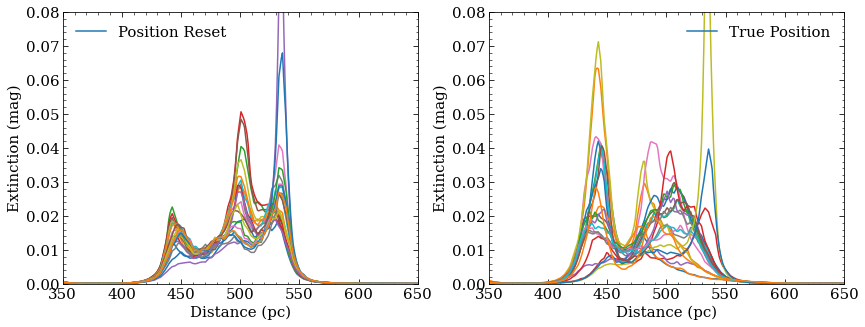

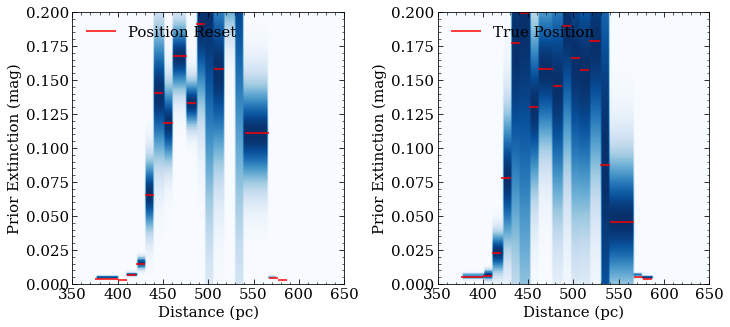

In [83]:
sl0 = sightlines[0]
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 5))
for i in range(len(sl0.stars)):
    label_false = '' if i != 0 else 'Position Reset'
    star = sl0.stars[i]
    l_ind, b_ind = find_nearest(star['GLON'], star['GLAT'], dust_data)
    dust_sightline = np.copy(dust_data.dustmap[b_ind, l_ind, :])
    axs[0].plot(dust_data.distance, dust_sightline, label = label_false)


    label_true = '' if i != 0 else 'True Position'
    l_ind, b_ind = find_nearest(star['GLON_True'], star['GLAT_True'], dust_data)
    dust_sightline = np.copy(dust_data.dustmap[b_ind, l_ind, :])   
    axs[1].plot(dust_data.distance, dust_sightline, label = label_true)


axs[0].set_ylabel('Extinction (mag)')
axs[0].set_xlabel('Distance (pc)')
axs[0].set_xlim(350, 650)
axs[0].set_ylim(0, 0.08)
axs[1].set_ylabel('Extinction (mag)')
axs[1].set_xlabel('Distance (pc)')
axs[1].set_xlim(350, 650)
axs[1].set_ylim(0, 0.08)
axs[0].legend()
axs[1].legend()
fig.set_facecolor('white')
plt.show()

###########################


prior_extent = (350, 650, 0, 0.2)
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
ax = axs[0]
sl = sightlines[0]
bins = sl.bins
image = generate_prior_image(sl, mult = 1)
ax.imshow(image.T, origin = 'lower', cmap = 'Blues', extent = prior_extent, aspect  = (prior_extent[1]-prior_extent[0])/(prior_extent[3]-prior_extent[2]))
ax.hlines(sl.voxel_dAVdd, bins[0:-1], bins[1:], color = 'r', label = 'Position Reset')
ax.set_xlim(350, 650)
ax.set_ylim(0, 0.2)
ax.legend(loc = "upper left")
ax.set_ylabel('Prior Extinction (mag)')
ax.set_xlabel('Distance (pc)')

ax = axs[1]
sl = sightlines_noreset[0]
bins = sl.bins
image = generate_prior_image(sl, mult = 1)
ax.imshow(image.T, origin = 'lower', cmap = 'Blues', extent = prior_extent, aspect = (prior_extent[1]-prior_extent[0])/(prior_extent[3]-prior_extent[2]))
ax.hlines(sl.voxel_dAVdd, bins[0:-1], bins[1:], color ='r', label = 'True Position')
ax.set_xlim(350, 650)
ax.set_ylim(0, 0.2)
ax.set_ylabel('Prior Extinction (mag)')
ax.set_xlabel('Distance (pc)')

ax.legend(loc = "upper left")
fig.set_facecolor('white')
plt.show()

In [28]:
from MCMCfns import logprob_dropreg 

def run_MCMC(sl, steps = 1000, nwalkers = 100, pool = None, filename = None):
    ndim = len(sl.voxel_dAVdd) 
    nstar = len(sl.stars)
    ndim_amp = int(ndim + ndim * nstar)


    if nwalkers < 2 * ndim_amp:
        nwalkers = 2 * ndim_amp + 5
        print('WARNING: nwalkers updated to', nwalkers)

    if filename is not None:
        backend = emcee.backends.HDFBackend(filename)
        backend.reset(nwalkers, ndim_amp)
    else:
        backend = None

    sampler = emcee.EnsembleSampler(nwalkers, ndim_amp , logprob_dropreg, 
                                    kwargs={'sl': sl, 'minval': 0,  'prior_mult':  1, 'v_max': 20, 'sigma': None}, pool = pool, backend = backend)
    # init = 12.5 *(np.random.random((nwalkers, ndim_amp)) - 0.5)
    init = 10 *  (np.random.random((nwalkers, ndim_amp)) - 0.5)

    init[:, ndim:] = np.abs(sl.dAVdd.ravel()[np.newaxis, :] + 0.1*(np.random.random(init[:, ndim:].shape)-0.5))
    print('NDIM:', ndim, 'NSTAR:', nstar, 'INITSHAPE:', init.shape)
    
    sampler.run_mcmc(init,  steps, progress = True);
    
    return sampler, ndim, ndim_amp

In [29]:

# lp_foreground = Logprior_Foreground(sl.l, sl.b)
# lp_foreground.logprior_foreground_v(10, 400)

```
def logprob_2(p, sl, logprior = logprior_v, loglikely = loglikely_2, **kwargs): ## NEW AS OF 05.16LIke.
    ndim = len(sl.voxel_dAVdd)
    v = p[ :ndim]
    av = p[ndim:].reshape(-1, ndim)
    lp = logprior(v, **kwargs)
    lp_davdd = logprior_davdd(av, AV_base = sl.dAVdd)
    lp_davdd_reg = logprior_davdd_reg(av, sl, **kwargs)
    lp_davdd_reg_group = logprior_davdd_reg_group(av, sl)
    if (not np.isfinite(lp)) | (not np.isfinite(lp_davdd)) | (not np.isfinite(lp_davdd_reg)):
        return -np.inf
    return lp + lp_davdd  + lp_davdd_reg + loglikely_2(v, av, sl = sl, **kwargs) + lp_davdd_reg_group # group term added 10.13


def logprob_fg(p, sl, lp_fore = None, **kwargs):
    ndim = len(sl.voxel_dAVdd)
    
    lprob = logprob_2(p, sl, **kwargs)
    v = p[ :ndim]
    av = p[ndim:].reshape(-1, ndim) #what shape is dAVddd? 

    ### Added 05.08 ###
    lprior_av_min = logprior_davdd_min(av)
    lprob = lprob + lprior_av_min

    lp_fore_v = lp_fore.logprior_foreground_v(v, sl.bins[1:])
    # lp_fore_av = lp_fore.logprior_foreground_av(av, sl.bins[1:])
    return lprob + lp_fore_v #+ lp_fore_av
```


TO BE DEBUGGED

[x] logprior_v only operates on velocity

[] lp_davdd

[] lp_davdd_reg 

[] lp_davdd_reg_group

[] lprior_av_min

[] lp_fore (maybe)



In [30]:
# Debugging priors and initializations!
sl = sightlines[0]
ndim = len(sl.voxel_dAVdd) 
nstar = len(sl.stars)
ndim_amp = int(ndim + ndim * nstar)
nwalkers = 100

init = 10 *  (np.random.random((nwalkers, ndim_amp)) - 0.5)

init[:, ndim:] = np.abs(sl.dAVdd.ravel()[np.newaxis, :] + 0.1*(np.random.random(init[:, ndim:].shape)-0.5))

from MCMCfns import logprior_v, logprior_davdd, logprior_davdd_reg, logprior_davdd_reg_group, logprior_davdd_min

In [31]:
init_slice = init[0, :]
v = init_slice[:ndim]
av = init_slice[ndim:].reshape(-1, ndim)

print(logprior_v(v))
print(logprior_davdd(av, AV_base=sl.dAVdd))
print(logprior_davdd_reg(av, sl))
print(logprior_davdd_reg_group(av, sl))
print(logprior_davdd_min(av, minval = 0))



0.0
0.0
-864.8962720694312
-3132.830310146728
0.0


In [32]:
for i in range(0, 100, 10):

    init_slice = init[0, :]
    v = init_slice[:ndim]
    av = init_slice[ndim:].reshape(-1, ndim)
    print('logprior_v', logprior_v(v))
    print('logprior_davdd',logprior_davdd(av, AV_base=sl.dAVdd))
    print('logprior_davdd_reg',logprior_davdd_reg(av, sl))
    print('logprior_davdd_reg_group', logprior_davdd_reg_group(av, sl))
    print('logprior_davdd_min', logprior_davdd_min(av, minval = 0))

logprior_v 0.0
logprior_davdd 0.0
logprior_davdd_reg -864.8962720694312
logprior_davdd_reg_group -3132.830310146728
logprior_davdd_min 0.0
logprior_v 0.0
logprior_davdd 0.0
logprior_davdd_reg -864.8962720694312
logprior_davdd_reg_group -3132.830310146728
logprior_davdd_min 0.0
logprior_v 0.0
logprior_davdd 0.0
logprior_davdd_reg -864.8962720694312
logprior_davdd_reg_group -3132.830310146728
logprior_davdd_min 0.0
logprior_v 0.0
logprior_davdd 0.0
logprior_davdd_reg -864.8962720694312
logprior_davdd_reg_group -3132.830310146728
logprior_davdd_min 0.0
logprior_v 0.0
logprior_davdd 0.0
logprior_davdd_reg -864.8962720694312
logprior_davdd_reg_group -3132.830310146728
logprior_davdd_min 0.0
logprior_v 0.0
logprior_davdd 0.0
logprior_davdd_reg -864.8962720694312
logprior_davdd_reg_group -3132.830310146728
logprior_davdd_min 0.0
logprior_v 0.0
logprior_davdd 0.0
logprior_davdd_reg -864.8962720694312
logprior_davdd_reg_group -3132.830310146728
logprior_davdd_min 0.0
logprior_v 0.0
logprior_dav

In [33]:
# sl.bins[1:].shape
# sl.dAVdd.shape

In [34]:
# print('ndim', sl.ndim)
# print('nsig', sl.nsig)
# print('signals shape', sl.signals.shape)
# print('dA(V)/dd shape', sl.dAVdd.shape)
# print('dA(V)/dd shape in logprob fn', sl.dAVdd.flatten().reshape(-1, sl.ndim).shape)

In [35]:
# sl.dAVdd

In [36]:
os.listdir(data_dir + '/modelfiles/RUNS')

['kt_240808a',
 '240723_InjectionFG',
 'kt_250108a_15-30',
 'kt_250110a',
 'kt_250110b',
 'kt_250114a',
 'kt_250121a',
 'kt_250110c',
 'kt_250122a',
 'kt_250122b',
 'kt_250122c',
 'kt_250122d',
 'kt_250127a',
 'kt_250128a',
 'kt_250128b',
 'kt_250128c',
 'kt_250128d',
 'kt_250212a',
 'kt_250212b',
 'kt_250212c',
 'kt_250212d',
 'kt_250212e',
 'kt_250212f',
 'kt_250213a',
 'kt_250213b',
 'kt_250213c',
 'kt_250213d',
 'kt_250213e',
 'kt_250213g',
 'kt_250213f']

In [37]:
kt_dir_list = os.listdir(data_dir + '/modelfiles/RUNS')


In [38]:
today = str(datetime.date.today()).split('-')
kt_dir_list = kt_dir_list = os.listdir(data_dir + '/modelfiles/RUNS')
datelabel = today[0][-2:]+today[1]+today[2]
same_dates = [name.startswith('kt_' + datelabel) for name in kt_dir_list]
same_date_names = np.array(kt_dir_list)[same_dates]


In [ ]:
stp = 1250

# sampler, ndim, ndim_amp = MCMC_scary(a, steps = stp, nwalkers = 500)
# sTHIsTThisterasdfdsfafsdfsdafampler1, ndim1, ndim_amp1 = MCMC(a1, steps = stp)
# sampler2, ndim2, ndim_amp2 = MCMC(a2, steps = stp)
# sampler3, ndim3, ndim_amp3 = MCMC(a3, steps = stp)

kt_dir_list = os.listdir(data_dir + '/modelfiles/RUNS')

if False:
    today = str(datetime.date.today()).split('-')
    datelabel = today[0][-2:]+today[1]+today[2]

    same_dates = [name.startswith('kt_' + datelabel) for name in kt_dir_list]
    same_date_names = np.array(kt_dir_list)[same_dates]
    select_letter = 0
    if len(same_date_names) > 0:
        letter = chr(ord('a') + select_letter)
        while letter in [name[-1] for name in same_date_names]:
            select_letter += 1
            letter = chr(ord('a') + select_letter)
    else:
        letter = 'a'

    run_label = 'kt_' + datelabel + letter
    print(run_label)
else:
    run_label = 'kt_250213h'
    print(run_label)


first_run = False
log_stats = True
save_individual = False

if first_run:

    if not os.path.exists(data_dir + 'modelfiles/RUNS/' + run_label):
        os.makedirs(data_dir + 'modelfiles/RUNS/' + run_label)
    directory = data_dir + 'modelfiles/RUNS/' + run_label
        
    with Pool(8) as pool:
        for i in range(len(sightlines)):
            # try:
            if True:
                sl_i = sightlines[i]
                time_start = time.time()
                smplr, ndm, ndm_amp = run_MCMC(sl_i, steps = stp, nwalkers = 1000, pool = pool, filename = directory + '/sampler_' + str(i) + '.h5')
                # mid = time.time()
                # print('Time mid - start', mid - start) # beat 7:22
                # smplr_, ndim_ = MCMC_vonly(sl_i, smplr, steps = 1200, nwalkers = 100, pool = None)
                # end = time.time()
                # print('Time end - start:',(end - start)/60)
                
                # sl_i.intake(smplr)
                time_stop = time.time()
                time_elapsed = time_stop - time_start
                time_elapsed_str = str(time_elapsed // 60) + 'm'+ str(round(time_elapsed % 60,4)) + 's'
                state = 'success'

                with open(directory + '/LOG.txt', mode = 'a') as log:
                    log.write('Run with {} stars'.format(len(sl_i.stars)) + ' | ' + time_elapsed_str + ' | ' + str(time_elapsed) +' | ' + state + '\n')
            # except Exception as e:
            #     print('Something went wrong')
            #     sl_i = None 
            #     state = 'fail'
            #     with open('RUNS_FG_SIGCLIP/' + run_label + '/FAILS.txt', mode = 'a') as fails:
            #         fails.write(str(e))
                
#             with open('/RUNS_H5/240604_SIGCLIP_3/' + run_label + '_LOG.txt', mode = 'r+') as log:
#                 logstring = time.asctime() + ' | ' + str(i) + ' | ' + state + '\n'
#                 log.write(logstring)
else: 
    directory = data_dir + 'modelfiles/RUNS/' + run_label



kt_250213h


NDIM: 18 NSTAR: 22 INITSHAPE: (1000, 414)


100%|██████████| 1250/1250 [07:10<00:00,  2.91it/s]


NDIM: 10 NSTAR: 10 INITSHAPE: (1000, 110)


100%|██████████| 1250/1250 [03:15<00:00,  6.38it/s]


In [40]:
"hello"

'hello'

In [41]:
name = run_label

# first_run = False

# if first_run:
#     # f = open('RUNS_H5/240531_SIGCLIP_3/sightlines_{}.pickle'.format(name),'wb')
#     f = open('RUNS_H5/240604_SIGCLIP_3/sightlines_{}.pickle'.format(name),'wb')

#     pickle.dump(sightlines, f )
#     f.close()
# # else:
#     # f = open('RUNS_FG_SIGCLIP/' + run_label + '/sightlines_{}.pickle'.format(name), 'rb')
# #     f = open('RUNS_H5/240604_SIGCLIP_3/sightlines_{}.pickle'.format(name),'wb')
# #     sightlines = pickle.load(f)

# #     f.close()

In [42]:
chains = []
probabilities = []
for i in range(len(sightlines)):
    path= directory + '/sampler_' + str(i) + '.h5'
    reader = emcee.backends.HDFBackend(path)
    chains.append(reader.get_chain())
    probabilities.append(reader.get_log_prob())

--- Sightline 0 ---
Chain, 0


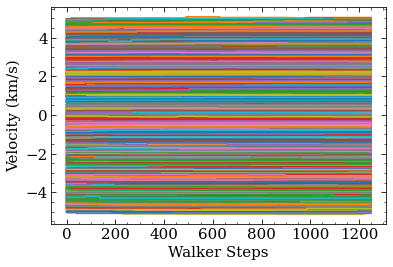

Chain, 5


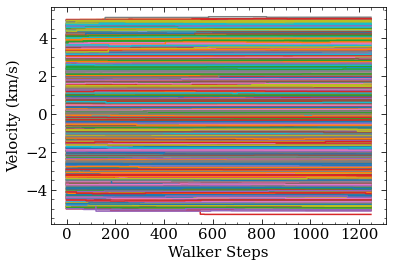

Chain, 10


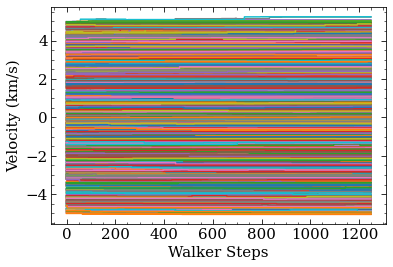

Chain, 15


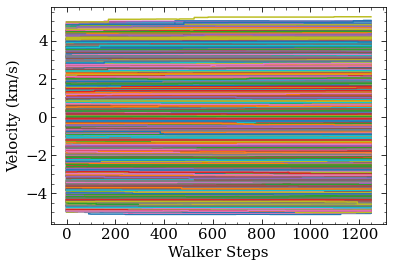

--- Sightline 1 ---
Chain, 0


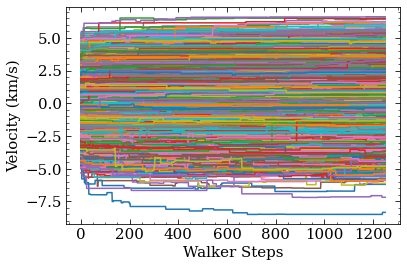

Chain, 5


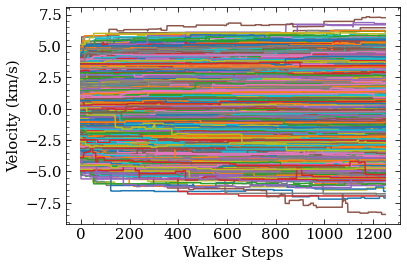

In [43]:
for i in range(len(sightlines)):
    print('--- Sightline', i, '---')
    sl = sightlines[i]
    ndim = sl.ndim
    for j in range(0, ndim, 5):
        fig, ax = plt.subplots()

        print('Chain,', j)
        ax.plot(chains[i][:, :, j])
        ax.set_xlabel('Walker Steps')
        ax.set_ylabel('Velocity (km/s)')
        plt.show()

N 0
ndim 18
nstars 22
medians shape (414,)
med_velo shape (18,)
med_dAV_dd shape (22, 18)
order_inds [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
signal_recreated.shape (22, 95)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


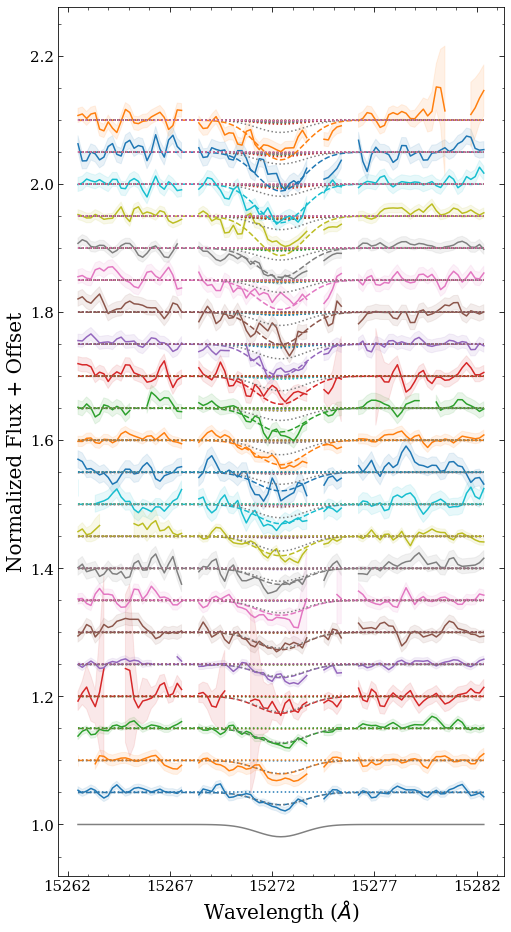

N 1
ndim 10
nstars 10
medians shape (110,)
med_velo shape (10,)
med_dAV_dd shape (10, 10)
order_inds [0 1 2 3 4 5 6 7 8 9]
signal_recreated.shape (10, 95)
0
1
2
3
4
5
6
7
8
9


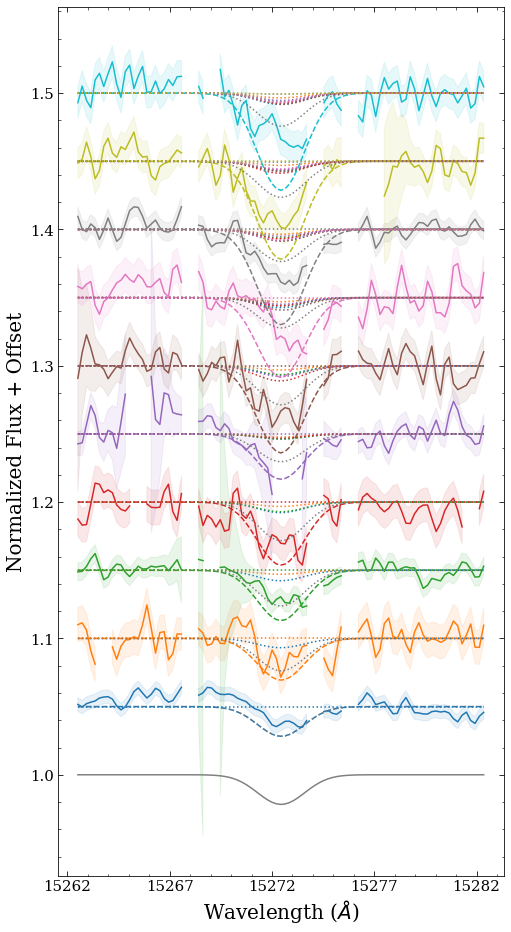

In [44]:
def model_signals_fg(rvelo, sl, dAVdd):
    # dAVdd = sl.dAVdd
    voxeldiffDIB = np.zeros((len(sl.stars), len(wavs_window)))
    unsummed_signals = np.zeros((len(sl.stars), len(sl.bins)-1,len(wavs_window)))
    # unsummed_signals = np.zeros((len(sl.bins)-1, len(sl.bins)-1,len(wavs_window)))

#     print(voxeldiffDIB.shape, unsummed_signals.shape, sl.dAVdd.shape)
    peak_wavelength = dopplershift(rvelo)
    wavs_grid = np.tile(wavs_window, (len(sl.bins) - 1, 1))
    voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
    amp = differentialAmplitude(dAVdd, sl.bins[1:]-sl.bins[:-1])

    def single_signal(amp, bindex):

        amp[bindex:] = 0 # THIS MIGHT NEED TO BE -1
        # print(amp)

        voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
        summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
        # continuum = lambda x, m, b : m * (x - lambda0) + b
        # cont = continuum(wavs_window, 0, b)
        return summed_DIB  + 1, voxel_DIB_scaled 

    fgdiffDIB = np.zeros((len(sl.stars), len(wavs_window)))
    

    for i in range(len(sl.stars)): # Iterate over each star in dAVdd array
#         print(dAVdd)
        dAVdd_bin = dAVdd[i, :] 

        amp = differentialAmplitude(dAVdd_bin, 1)

        bin_index = np.concatenate([sl.bin_inds]).astype(int)[i] # this only goes to 
        # signals[i, :] = single_signal(bin_index)
        voxeldiffDIB[i, :], unsummed_signals[i, :, :] = single_signal(amp, bin_index)
        fgdiffDIB[i, :], _ = single_signal(amp, 1)


    return voxeldiffDIB, unsummed_signals, fgdiffDIB

def plot_DIBS_fg(chain, sl, plot_objs = None, bestprob = False, lnprob = None):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8, 16))
    else:
        fig, ax = plot_objs

    ndim = len(sl.voxel_dAVdd)
    print('ndim', ndim)
    nstars = len(sl.stars)
    print('nstars', nstars)

    samples = chain[:, :, :].reshape((-1, chain.shape[-1]))

    medians = np.nanmedian(samples[-100:, :], axis = 0)
    print('medians shape', medians.shape)

    ## NEW THING
    if bestprob:
        lp =lnprob
        lp[:, :-100] = -np.infty
        w_ind, stp_ind = np.unravel_index(np.argmax(lp), lp.shape)

        medians = chain[w_ind, stp_ind, :]

    med_velo = medians[:ndim]

    med_dAV_dd = medians[ndim:].reshape(-1, ndim)
#     print(med_dAV_dd)
    print('med_velo shape', med_velo.shape)
    print('med_dAV_dd shape', med_dAV_dd.shape)
    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

    order_inds = np.array(np.argsort(sl.stars['DIST']))
    # order_inds = (np.array(np.argsort(sl.stars['DIST'])))
    print('order_inds', order_inds)

    signal_recreated, signal_recreated_unsummed, fg_dibs = model_signals_fg(med_velo, sl, med_dAV_dd) 

    print('signal_recreated.shape', signal_recreated.shape)


    ax.plot(wavs[window], fg_dibs[0, :], linestyle = 'solid', color ='grey')

    for i in range(len(order_inds)):
        ii = order_inds[i]
        print(ii)
        offset_i = i+1

        # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])

        ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * offset_i, color = 'C{}'.format(i))
        ax.fill_between(wavs_window, sl.signals[ii, :] + sl.signal_errs[ii, :] + 0.05 * offset_i,
                         sl.signals[ii, :] - sl.signal_errs[ii, :] + 0.05 * offset_i, color = 'C{}'.format(i), alpha = 0.1)

        ax.plot(wavs_window, signal_recreated[ii, :] + 0.05 * offset_i , color = 'C{}'.format(i), linestyle = 'dashed',)# label = 'recreated signal')

        for j in range(len(sl.bins)-1):
            if j==0:
                col = 'grey'
            else:
                col = 'C{}'.format(j-1)
            if j > i+1:
                continue
            ax.plot(wavs_window, signal_recreated_unsummed[ii, j, : ] + 1  + 0.05 * offset_i, color=col, linestyle = 'dotted', alpha = 1)

    # ax.legend(loc = 'lower left', fontsize = 20)

    ax.set_xlabel('Wavelength ($\AA$)', fontsize = 20)
    ax.set_ylabel('Normalized Flux + Offset', fontsize = 20)
    fig.set_facecolor('white')

    # ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))
    ax.set_xticks(np.linspace(15272-10, 15272 + 10, 5))

    # ax.set_yticklabels('')

    return signal_recreated, sl.signals, sl.signal_errs

chi2s = np.zeros(len(sightlines))
sl_lensignals = np.zeros(len(sightlines))

recreated_signals = []

for i in range(len(sightlines)):
    print('N', i)
    fig, ax = plt.subplots(figsize = (8, 16))

    sl_i = sightlines[i]
    sl_lensignals[i] = sl_i.nsig
    chain_i = chains[i]
    lp_i = probabilities[i]
    reproducedDIBs, realDIBs, realDIBerrs = plot_DIBS_fg(chain_i, sl_i, plot_objs = (fig, ax), lnprob = lp_i)

    chi2 = np.nansum((realDIBs-reproducedDIBs)**2 / realDIBerrs**2) / np.sum(np.isnan(realDIBs) == False)
    chi2s[i] = chi2

    # ymin, ymax = ax.get_ylim()
    # ax.text(lambda0, ymax - .01, str(chi2))

    # lp_i = sampler_i.lnprobability
    lp_med_i = np.nanmedian(lp_i[:, -100:])
    # ax.text(lambda0, ymax - .01, 'sl index {}'.format(i) )
    # ax.text(lambda0, ymax - .015, 'lnprob {}'.format(lp_med_i) )

    name_i = 'dibs_' + str(i)
#     fig.savefig('RUNS_H5/figures_0602a/0602a_DIBmodels/model_sl{}.png'.format(name_i))

    plt.show()

    ### Added 05.13 ###
    recreated_signals.append(reproducedDIBs)

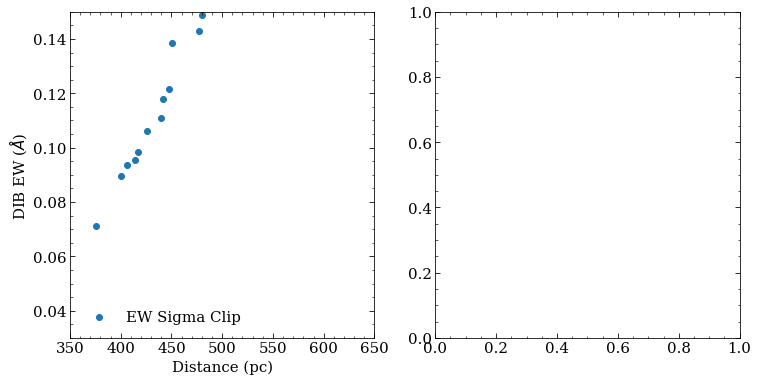

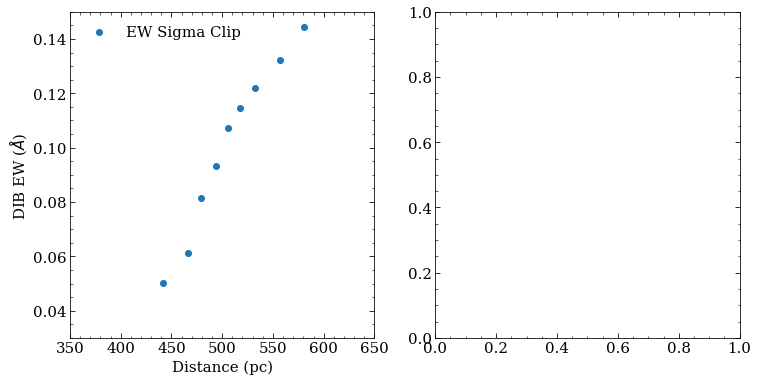

In [45]:
for i in range(len(sightlines)):   
    sl = sightlines[i]
    # sl_norestr = sightlines_norestr[i]
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))
    ax = axs[0]
    ax.scatter(sl.stars['DIST'], sl.stars['DIB_EQW'], label = "EW Sigma Clip")
    ax.set_xlabel('Distance (pc)')
    ax.set_ylabel('DIB EW ($\AA$)')
    ax.set_xlim(350, 650)
    ax.set_ylim(0.03, 0.15)
    ax.legend()

    # ax = axs[1]
    # ax.scatter(sl_norestr.stars['DIST'], sl_norestr.stars['DIB_EQW'], label = "EW Sigma Clip")
    # ax.set_xlabel('Distance (pc)')
    # ax.set_ylabel('DIB EW ($\AA$)')
    # ax.set_xlim(350, 650)
    # ax.set_ylim(0.03, 0.15)
    # ax.legend()

    # fig.set_facecolor('white')
    # plt.show()

In [46]:
def plot_velo(chain, sl , min_walker = None, plot_objs = None, color = None, plot_lines = False, plot_box = False, plot_violin = False, bestprob = False, lnprob = None):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8,6))
    else:
        fig, ax = plot_objs
    ndim = len(sl.voxel_dAVdd)

    walker_max = chain.shape[0]

    if min_walker is None:
        min_walker_val = -100
    # else:
    min_walker_val = walker_max - min_walker

    samples = chain[min_walker_val:, :, :].reshape((-1, chain.shape[-1]))

    vel_samples = samples[:, :sl.ndim]
    avg_av = np.nansum(np.median(sl.dAVdd, axis = 0))

    medians = np.nanmedian(samples[:, :], axis = 0)
    if bestprob:
        lp = lnprob
        lp[:, :-100] = -np.infty
        w_ind, stp_ind = np.unravel_index(np.argmax(lp), lp.shape)

        medians = chain[w_ind, stp_ind, :]

    stdevs = np.nanstd(samples[min_walker_val:, :], ddof = 1, axis = 0)

    med_velo = medians[:ndim]
    std_velo = stdevs[:ndim]


    med_dAV_dd = medians[ndim:]
    med_dAV_dd = stdevs[ndim:]

    perc16, perc50,  perc84 = (np.percentile(samples[min_walker_val:, :], 16, axis = 0), 
                               np.percentile(samples[min_walker_val:, :], 50, axis = 0),
                               np.percentile(samples[min_walker_val:, :], 84, axis = 0) )
    velo16, velo50, velo84 = (perc16[:ndim], perc50[:ndim], perc84[:ndim])

   
    if color == None:
        color_choice = 'k'
    else:
        color_choice = color
    

    if plot_box:
        # ax.hlines(med_velo, sl.bins[:-1], sl.bins[1:], color = color_choice, linestyle = 'dashed', linewidth = 0.5)
        # ax.hlines(velo50, sl.bins[:-1], sl.bins[1:], color = color_choice)
        ax.hlines(velo50, sl.bins[:-1], sl.bins[1:], color = 'k')


        for j in range(len(sl.bins)-1):
            # ax.fill_between([sl.bins[i], sl.bins[i +1]], med_velo[i]+std_velo[i], med_velo[i]-std_velo[i], 
            #                 alpha = 0.3, color = color_choice, hatch = '/')
            ax.fill_between([sl.bins[j], sl.bins[j +1]], velo84[j], velo16[j], 
                    alpha = 0.3, color = 'C{}'.format(j))

    axmin = 350
    if plot_violin:
        colorlist = ['grey', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']
        bin_pos = sl.bins[:]
        bin_pos[0] = axmin
        pos = (bin_pos[1:] + bin_pos[:-1])/2
        
        w = (bin_pos[1:] - bin_pos[:-1])
        vparts=ax.violinplot(vel_samples, pos, widths = w, showmeans=False, showextrema=False, showmedians=True, side = 'both')
        for vindx, part in enumerate(vparts['bodies']):
            part.set_facecolor( 'C'+str(vindx))

            
        plot_guides = True
        if plot_guides:
            for pos in bin_pos:
                ax.plot((pos, pos), (-10, 20), color = 'k', linestyle = 'dotted')
                axs[1].plot((pos, pos), (0, 1), color = 'k', linestyle = 'dotted')
    
    plot_violin_half = False
    if plot_violin_half:
        colorlist = ['grey', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']
        bin_pos = sl.bins[:]
        bin_pos[0] = axmin
        pos =  bin_pos[1:]
        
        w = np.min(2* (bin_pos[1:] - bin_pos[:-1]))
        vparts=ax.violinplot(vel_samples, pos, widths = w, showmeans=False, showextrema=False, showmedians=True, side = 'low')
        for vindx, part in enumerate(vparts['bodies']):
            part.set_facecolor(colorlist[vindx])


    # else:  
    #     # ax.errorbar((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
    #     # ax.scatter((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, c = color_choice)
    #     ax.errorbar((sl.bins[1:] ) , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
    #     ax.scatter((sl.bins[1:] ) , med_velo, c = color_choice)
    #     if plot_lines:
    #         ax.hlines(med_velo, sl.bins[:-1], sl.bins[1:], color = color_choice, linestyle = 'solid', linewidth = .5)



    # ax.errorbar((sl.bins[1:]),med_velo, xerr = (sl.bins[1:] - sl.bins[:-1], np.zeros(med_velo.shape)), yerr = std_velo, fmt = '.' )
    ax.set_xlim(axmin, 600)
    ax.set_xlabel('Distance (pc)')
    ax.set_ylabel('Radial Velocity (km/s)')

    dist_xx = (sl.bins[1:] + sl.bins[:-1] ) /2
    # med_velo

    return fig, ax, dist_xx, med_velo, std_velo

N  0
[362.72711182 387.98104858 405.51287842 415.52288818 425.53289795
 435.54290771 445.55291748 455.56292725 468.70858765 481.85424805
 491.86425781 501.87426758 511.88427734 523.13934326 534.73742676
 553.30859375 571.5368042  581.54681396]
[ 0.1835335  -0.31262977 -0.05243087  0.00422884  0.22123157  0.02962509
  0.14144433 -0.1762904   0.10522886 -0.17084103 -0.09565575 -0.13714295
  0.14294674 -0.03440528 -0.03376472 -0.32552748 -0.13808098 -0.01342909]
[405.51287842 415.52288818 425.53289795 435.54290771 445.55291748
 455.56292725 468.70858765 481.85424805 491.86425781 501.87426758
 511.88427734 523.13934326 534.73742676 553.30859375 571.5368042
 581.54681396]
(array([-0.0010663 ,  0.48748271]), array([[ 3.94179313e-07, -1.92156536e-04],
       [-1.92156536e-04,  9.47965826e-02]]))


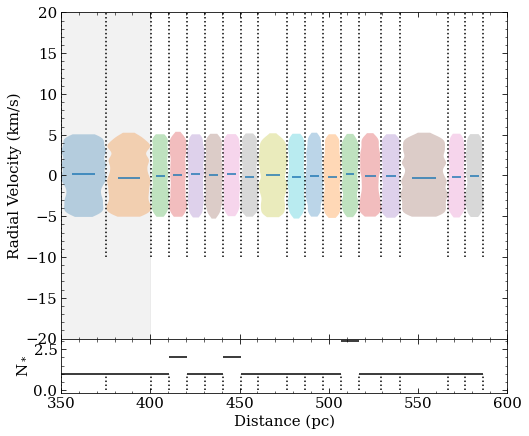

N  1
[396.04827881 454.20202637 472.81533813 486.52539062 499.59381104
 511.29644775 524.81829834 544.7434082  568.6104126  585.5847168 ]
[ 0.30789962  0.4075666   0.09151041  0.18262016  0.01604568  0.1755624
  0.12558278  0.08113919 -0.33626084 -0.29422026]
[454.20202637 472.81533813 486.52539062 499.59381104 511.29644775
 524.81829834 544.7434082  568.6104126  585.5847168 ]
(array([-0.00457833,  2.41256686]), array([[ 1.04598840e-06, -5.40346863e-04],
       [-5.40346863e-04,  2.80949733e-01]]))


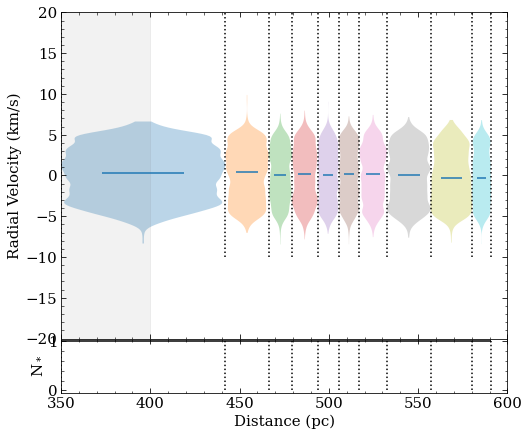

In [47]:
avs = np.zeros(len(sightlines))
for i in range(len(sightlines)):
    sl_i = sightlines[i]
    avs[i] = np.sum(sl_i.voxel_dAVdd)

line = lambda x, m, b : m * x + b

cnorm = matplotlib.colors.Normalize(np.min(avs), np.max(avs))
cmap = plt.get_cmap('viridis')
mappable = matplotlib.cm.ScalarMappable(norm = cnorm,  cmap = cmap)


sightlines_slopes = np.zeros(len(sightlines))
sightlines_slopes_err = np.zeros(len(sightlines))


dist_xx_sl = np.array([])
velo_yy_sl = np.array([])
std_velo_sl = np.array([])

priorx = np.linspace(-20, 20, 100)

# for i in range(len(sightlines)): 
for i in range(0, len(sightlines)): 

    print('N ', i)
    fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (8,7), sharex = True, gridspec_kw={'height_ratios': [6,1], 'hspace': 0})

    

    dist_xx = np.array([])
    velo_yy = np.array([])
    std_velo = np.array([])
    sl_i = sightlines[i]
    color = cmap(cnorm(avs[i]))
    color = 'C'+str(i)
    _, __, dist_xx_i, velo_yy_i, std_velo_i = plot_velo(chains[i], sl = sl_i, min_walker = 10, plot_objs = (fig, axs[0]), color = color, 
                                                        plot_box = False, plot_violin=True, bestprob = False, lnprob = probabilities[i])
    dist_xx = np.concatenate([dist_xx, dist_xx_i])
    velo_yy = np.concatenate([velo_yy, velo_yy_i])
    std_velo = np.concatenate([std_velo, std_velo_i])

    print(dist_xx)
    print(velo_yy)



    dist_sort = np.argsort(dist_xx)
    # print(dist_sort)

    try:
        filt = (dist_xx[dist_sort] > 400) & (dist_xx[dist_sort] <= 800)
        print(dist_xx[dist_sort][filt])
        fit_result = curve_fit(line, dist_xx[dist_sort][filt], velo_yy[dist_sort][filt], sigma = std_velo[dist_sort][filt])
        print(fit_result)
        fit_params = fit_result[0]
        fit_result_err = np.sqrt(np.diag(fit_result[1]))
        xx_plot = np.linspace(380, 600)

        # axs[0].plot(xx_plot, line(xx_plot, fit_params[0], fit_params[1]), label = 'SL ' + str(i))
        sightlines_slopes[i] = fit_params[0] 
        sightlines_slopes_err[i] = fit_result_err[0]
    except Exception as e:
        print('didn\'t fit properly')
        print(e)
        sightlines_slopes[i] = np.nan

    # ### ADDDED 03.28 ###
    # fgprior = prior_for_plot(sl_i.l, sl_i.b, priorx)
    # axs[0].plot(5e2 * fgprior + 350, priorx, color = 'grey', linestyle = 'dashed')

    # ### ADDED 03.31 ###
    # profile, rvel = get_CO_profile(sl_i.l, sl_i.b)
    # axs[0].plot(600- 5e1*profile, rvel)

#     axs[1].plot(dust_data.distance, sl_davdd[i, :], color = 'k')
#     # ax.set_ylim(ymin, ymax)
#     axs[1].set_xlim(350, 600)
#     axs[1].set_xlabel('Distance (pc)')
#     axs[1].set_ylabel(r'$ \langle \frac{dA_V}{dd} \rangle $' + '\n (mag/pc)')
#     axs[1].set_ylim(0, 0.05)
    fig.set_facecolor('white')

    # ylim0 = (-vv[i]* 1.2, +vv[i]*1.2)
    ylim0 = (-20, 20)
    axs[0].set_ylim(*ylim0)
    axs[0].fill_between((350, 400), (ylim0[1], ylim0[1]), (ylim0[0], ylim0[0]), color = 'grey', alpha = 0.1)

    # ylim1 = (-0.001, 0.05)
#     axs[1].set_ylim(*ylim1)
#     axs[1].fill_between((350, 400), (ylim1[1], ylim1[1]), (ylim1[0], ylim1[0]), color = 'grey', alpha = 0.1)

    # for j in range(len(sl_i.stars)):
    #     axs[1].scatter(sl_i.stars['DIST'][j], sl_davdd[i, find_nearest_dist(sl_i.stars['DIST'][j])])

    # axs[0].legend()
    # name_i = 'veldist_' + str(i)
#     fig.savefig('RUNS_H5/figures_0602a/0602a_VelModels/velo_plot_{}.png'.format(i) )


    # vrange, scale = vv[i], 0
    # rvelo, star_loc_rvelo_scattered, star_locs = velo_profile(vrange, scale = scale)
    # axs[0].plot(dust_data.distance, rvelo, color = 'r', linestyle = 'dotted')

    # aux_axis = axs[0].aux_axis['0, 1, 1, 0.01']

    axs[1].hlines(np.bincount(sl_i.bin_inds)[1:], sl_i.bins[:-1], sl_i.bins[1:],  color = 'k')
    axs[1].set_xlabel('Distance (pc)')
    axs[1].set_ylabel('N$_*$')

    plt.show()

    dist_xx_sl = np.concatenate([dist_xx_sl, dist_xx])
    velo_yy_sl = np.concatenate([velo_yy_sl, velo_yy])
    std_velo_sl = np.concatenate([std_velo_sl, std_velo])

In [48]:
sightlines[0].bin_inds
# print(sightlines[0].bins)
print(len(np.bincount(sightlines[0].bin_inds)))
print(len(sightlines[0].bins))

19
19


In [49]:
dist_xx_sl

array([362.72711182, 387.98104858, 405.51287842, 415.52288818,
       425.53289795, 435.54290771, 445.55291748, 455.56292725,
       468.70858765, 481.85424805, 491.86425781, 501.87426758,
       511.88427734, 523.13934326, 534.73742676, 553.30859375,
       571.5368042 , 581.54681396, 396.04827881, 454.20202637,
       472.81533813, 486.52539062, 499.59381104, 511.29644775,
       524.81829834, 544.7434082 , 568.6104126 , 585.5847168 ])

(array([1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 1., 1., 3., 1., 1., 1., 1.,
        1.]),
 array([350.        , 375.45422363, 400.50787354, 410.5178833 ,
        420.52789307, 430.53790283, 440.5479126 , 450.55792236,
        460.56793213, 476.84924316, 486.85925293, 496.8692627 ,
        506.87927246, 516.88928223, 529.3894043 , 540.08544922,
        566.53179932, 576.54180908, 586.55181885]),
 <BarContainer object of 18 artists>)

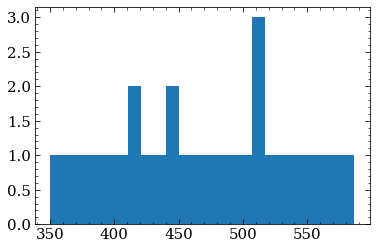

In [50]:
plt.hist(sightlines[0].stars['DIST'], bins = sightlines[0].bins)

In [51]:
# 0517a: 5 sightline run with previous standard priors, etc, likelihood mutiplied by 2
# 0517b: 5 sightline run with previous standard priors, etc, likelihood mutiplied by 4
# 0517c: should be a normal kt run liike 0513a, first 20 sightlines. This should be my baseline, basically
# 0530a: maintains no Gaussian priors on extinction (other than the foreground. 5 sightlines, 1000 steps, 500 walkers


In [52]:
# fig, ax = plt.subplots()
# ax.plot(sightlines[0].sampler.chain[:, :, 0].T, color = 'k', alpha = 0.1)

In [53]:
def polynomial2d( x1, x2, theta = None, uncert = None):  
        if theta is None:
            theta = np.array([5.03964666, -1.04129592, -0.72842925, -0.20292219,  0.0206567,  -0.14442016])
        if uncert is None:
            uncert = 2.404363059339516
        if np.array(x1).ndim != 1:
            x1 = np.array([x1])
            x2 = np.array([x2])
        x1 = x1 - 160 # FOR CA CLOUD SPECIFICIALLY
        x2 = x2 + 8 # DITTO
        X = np.array([[np.ones(np.array(x1).shape), x1, x2, x1 * x2, x1**2, x2**2]]).T
        matrix = X * theta[:, np.newaxis]
        print(matrix.shape)
        return np.nansum(matrix, axis = 1).flatten()

def box(x, min = -8.5, max = 17.5):
     y = np.ones(len(x))
     y[x < min] = 0
     y[x > max] = 0
     return y

def prior_for_plot(l, b, x ):
    gaussn = lambda x, mu, sig : 1/(np.sqrt(2 * np.pi) * sig) * np.exp(-(x - mu)**2 / (2* sig**2))     
    # x = np.linspace(-20, 20, 100)
    sig =  2.404363059339516
    mu = polynomial2d(l, b)
    print(mu)
    return gaussn(x, mu, sig) #* box(x)

priorx = np.linspace(-20, 20, 100)

In [54]:
def make_corner(sampler, labels, minval = 50):
    dim = sampler.chain.shape[-1]
    samples = sampler.chain[:, minval:, :].reshape((-1, dim))
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    plt.show()

def make_corner_vonly(sampler, ndim, labels, minval = -100):
    samples = sampler.chain[:, minval:, :ndim].reshape((-1, ndim))
    print(samples.shape)
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    return fig
    plt.show()

if False:
    for i in range(0, len(sightlines)):
        sl_i = sightlines[i]
        ndim = len(sl_i.bins) - 1 
        fig = make_corner_vonly(sl_i.sampler, ndim, labels = None, minval =-200)
        axes = np.array(fig.axes).reshape(ndim, ndim)
        axes[0, 0].plot(priorx, 1e5* prior_for_plot(sl_i.l, sl_i.b, priorx))
        plt.show()

In [55]:
# def model_signals_fg(rvelo, sl, dAVdd):
#     # dAVdd = sl.dAVdd
#     voxeldiffDIB = np.zeros((len(sl.stars), len(wavs_window)))
#     unsummed_signals = np.zeros((len(sl.stars), len(sl.bins)-1,len(wavs_window)))
#     # unsummed_signals = np.zeros((len(sl.bins)-1, len(sl.bins)-1,len(wavs_window)))

# #     print(voxeldiffDIB.shape, unsummed_signals.shape, sl.dAVdd.shape)
#     peak_wavelength = dopplershift(rvelo)
#     wavs_grid = np.tile(wavs_window, (len(sl.bins) - 1, 1))
#     voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
#     amp = differentialAmplitude(dAVdd, sl.bins[1:]-sl.bins[:-1])

#     def single_signal(amp, bindex):

#         amp[bindex:] = 0 # THIS MIGHT NEED TO BE -1
#         # print(amp)

#         voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
#         summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
#         # continuum = lambda x, m, b : m * (x - lambda0) + b
#         # cont = continuum(wavs_window, 0, b)
#         return summed_DIB  + 1, voxel_DIB_scaled 

#     fgdiffDIB = np.zeros((len(sl.stars), len(wavs_window)))
    

#     for i in range(len(sl.stars)): # Iterate over each star in dAVdd array
# #         print(dAVdd)
#         dAVdd_bin = dAVdd[i, :] 

#         amp = differentialAmplitude(dAVdd_bin, 1)

#         bin_index = np.concatenate([sl.bin_inds]).astype(int)[i] # this only goes to 
#         # signals[i, :] = single_signal(bin_index)
#         voxeldiffDIB[i, :], unsummed_signals[i, :, :] = single_signal(amp, bin_index)
#         fgdiffDIB[i, :], _ = single_signal(amp, 1)


#     return voxeldiffDIB, unsummed_signals, fgdiffDIB

# def plot_DIBS_fg(sampler, sl, plot_objs = None, bestprob = False):
#     if plot_objs == None:
#         fig, ax = plt.subplots(figsize = (8, 16))
#     else:
#         fig, ax = plot_objs

#     ndim = len(sl.voxel_dAVdd)
#     print('ndim', ndim)
#     nstars = len(sl.stars)
#     print('nstars', nstars)

#     samples = sampler.chain[:, :, :].reshape((-1, sampler.chain.shape[-1]))

#     medians = np.nanmedian(samples[-100:, :], axis = 0)
#     print('medians shape', medians.shape)

#     ## NEW THING
#     if bestprob:
#         lp = sl.sampler.lnprobability
#         lp[:, :-100] = -np.infty
#         w_ind, stp_ind = np.unravel_index(np.argmax(lp), lp.shape)

#         medians = sl_i.sampler.chain[w_ind, stp_ind, :]

#     med_velo = medians[:ndim]

#     med_dAV_dd = medians[ndim:].reshape(-1, ndim)
# #     print(med_dAV_dd)
#     print('med_velo shape', med_velo.shape)
#     print('med_dAV_dd shape', med_dAV_dd.shape)
#     # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

#     order_inds = np.array(np.argsort(sl.stars['DIST']))
#     # order_inds = (np.array(np.argsort(sl.stars['DIST'])))
#     print('order_inds', order_inds)

#     signal_recreated, signal_recreated_unsummed, fg_dibs = model_signals_fg(med_velo, sl, med_dAV_dd) 

#     print('signal_recreated.shape', signal_recreated.shape)


#     ax.plot(wavs[window], fg_dibs[0, :], linestyle = 'solid', color ='grey')

#     for i in range(len(order_inds)):
#         ii = order_inds[i]
#         print(ii)
#         offset_i = i+1

#         # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])

#         ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * offset_i, color = 'C{}'.format(i))
#         ax.fill_between(wavs_window, sl.signals[ii, :] + sl.signal_errs[ii, :] + 0.05 * offset_i,
#                          sl.signals[ii, :] - sl.signal_errs[ii, :] + 0.05 * offset_i, color = 'C{}'.format(i), alpha = 0.1)

#         ax.plot(wavs_window, signal_recreated[ii, :] + 0.05 * offset_i , color = 'C{}'.format(i), linestyle = 'dashed',)# label = 'recreated signal')

#         for j in range(len(sl.bins)-1):
#             if j==0:
#                 col = 'grey'
#             else:
#                 col = 'C{}'.format(j-1)
#             if j > i+1:
#                 continue
#             ax.plot(wavs_window, signal_recreated_unsummed[ii, j, : ] + 1  + 0.05 * offset_i, color=col, linestyle = 'dotted', alpha = 1)

#     # ax.legend(loc = 'lower left', fontsize = 20)

#     ax.set_xlabel('Wavelength ($\AA$)', fontsize = 20)
#     ax.set_ylabel('Normalized Flux + Offset', fontsize = 20)
#     fig.set_facecolor('white')

#     # ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))
#     ax.set_xticks(np.linspace(15272-10, 15272 + 10, 5))

#     # ax.set_yticklabels('')

#     return signal_recreated, sl.signals, sl.signal_errs

# chi2s = np.zeros(len(sightlines))
# sl_lensignals = np.zeros(len(sightlines))

# recreated_signals = []

# for i in range(len(sightlines)):
#     print('N', i)
#     fig, ax = plt.subplots(figsize = (8, 16))

#     sl_i = sightlines[i]
#     sl_lensignals[i] = sl_i.nsig
#     sampler_i = sl_i.sampler
#     reproducedDIBs, realDIBs, realDIBerrs = plot_DIBS_fg(sampler_i, sl_i, plot_objs = (fig, ax))

#     chi2 = np.nansum((realDIBs-reproducedDIBs)**2 / realDIBerrs**2) / np.sum(np.isnan(realDIBs) == False)
#     chi2s[i] = chi2

#     # ymin, ymax = ax.get_ylim()
#     # ax.text(lambda0, ymax - .01, str(chi2))

#     lp_i = sampler_i.lnprobability
#     lp_med_i = np.nanmedian(lp_i[:, -100:])
#     # ax.text(lambda0, ymax - .01, 'sl index {}'.format(i) )
#     # ax.text(lambda0, ymax - .015, 'lnprob {}'.format(lp_med_i) )

#     name_i = 'dibs_' + str(i)
#     # fig.savefig('RUNS_H5/figures_0602a/0602a_DIBmodels/model_sl{}.png'.format(name_i))

#     plt.show()

#     ### Added 05.13 ###
#     recreated_signals.append(reproducedDIBs)


In [56]:
sl_davdd = np.zeros((len(l_sample.flatten()), dust_data.dustmap.shape[-1]))
for i in range(len(l_sample.flatten())): 
    l_i, b_i = l_sample.flatten()[i], b_sample.flatten()[i]
    l_ind, b_ind = find_nearest(l_i, b_i)
    sl_davdd[i, :] = np.copy(dust_data.dustmap[b_ind, l_ind, :])


In [57]:
for i in range(len(sightlines)):
    sl = sightlines[i]
    recreated_signals_i = recreated_signals[i]

    chi2_per_signal = np.nansum((sl.signals - recreated_signals_i)**2 / recreated_signals_i, axis = 1)
    print(chi2_per_signal)

[0.0024705  0.00378774 0.00310585 0.01216342 0.00251728 0.00731522
 0.00680513 0.00849175 0.00618501 0.00878502 0.01406809 0.00383166
 0.00609245 0.01090748 0.0037601  0.0121148  0.01060224 0.00443803
 0.01161395 0.00602317 0.01675014 0.02019666]
[0.00501223 0.0098127  0.00377338 0.00933683 0.00962883 0.01435907
 0.02147503 0.01285901 0.0127962  0.01985142]


[0.96039023 1.45079277]


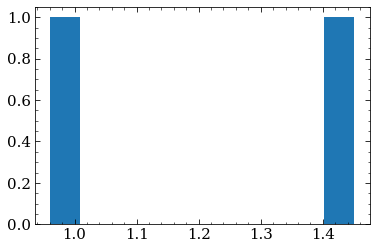

In [58]:
fig, ax = plt.subplots()
ax.hist(chi2s)
print(chi2s)

In [59]:
def plot_velo(sampler, sl , min_walker = None, plot_objs = None, color = None, plot_lines = False, plot_box = False, plot_violin = False, bestprob = False,):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8,6))
    else:
        fig, ax = plot_objs
    ndim = len(sl.voxel_dAVdd)

    walker_max = sampler.chain.shape[1]

    if min_walker is None:
        min_walker_val = -100
    # else:
    min_walker_val = walker_max - min_walker

    samples = sampler.chain[:, min_walker_val:, :].reshape((-1, sampler.chain.shape[-1]))

    vel_samples = samples[:, :sl.ndim]
    avg_av = np.nansum(np.median(sl.dAVdd, axis = 0))

    medians = np.nanmedian(samples[min_walker_val:, :], axis = 0)
    if bestprob:
        lp = sl_i.sampler.lnprobability
        lp[:, :-100] = -np.infty
        w_ind, stp_ind = np.unravel_index(np.argmax(lp), lp.shape)

        medians = sl_i.sampler.chain[w_ind, stp_ind, :]

    stdevs = np.nanstd(samples[min_walker_val:, :], ddof = 1, axis = 0)

    med_velo = medians[:ndim]
    std_velo = stdevs[:ndim]


    med_dAV_dd = medians[ndim:]
    med_dAV_dd = stdevs[ndim:]

    perc16, perc50,  perc84 = (np.percentile(samples[min_walker_val:, :], 16, axis = 0), 
                               np.percentile(samples[min_walker_val:, :], 50, axis = 0),
                               np.percentile(samples[min_walker_val:, :], 84, axis = 0) )
    velo16, velo50, velo84 = (perc16[:ndim], perc50[:ndim], perc84[:ndim])

    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)


    # ax.scatter((a.bins[1:] + a.bins[:-1] ) /2 , med_velo)
    # if
    # for i in range(len(sl.bins)-1): 
    #     ax.hlines(med_velo[i], sl.bins[i], sl.bins[i+1], linestyle = 'dashed')
    #     if i < len(sl.bins) -2:
    #         ax.vlines(sl.bins[i+1], med_velo[i], med_velo[i+1], linestyle = 'dashed')

    if color == None:
        color_choice = 'k'
    else:
        color_choice = color
    

    if plot_box:
        # ax.hlines(med_velo, sl.bins[:-1], sl.bins[1:], color = color_choice, linestyle = 'dashed', linewidth = 0.5)
        # ax.hlines(velo50, sl.bins[:-1], sl.bins[1:], color = color_choice)
        ax.hlines(velo50, sl.bins[:-1], sl.bins[1:], color = 'k')


        for j in range(len(sl.bins)-1):
            # ax.fill_between([sl.bins[i], sl.bins[i +1]], med_velo[i]+std_velo[i], med_velo[i]-std_velo[i], 
            #                 alpha = 0.3, color = color_choice, hatch = '/')
            ax.fill_between([sl.bins[j], sl.bins[j +1]], velo84[j], velo16[j], 
                    alpha = 0.3, color = 'C{}'.format(j))

    axmin = 350
    if plot_violin:
        colorlist = ['grey', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']
        bin_pos = sl.bins[:]
        bin_pos[0] = axmin
        pos = (bin_pos[1:] + bin_pos[:-1])/2
        
        w = (bin_pos[1:] - bin_pos[:-1])
        vparts=ax.violinplot(vel_samples, pos, widths = w, showmeans=False, showextrema=False, showmedians=True, side = 'both')
        for vindx, part in enumerate(vparts['bodies']):
            part.set_facecolor(colorlist[vindx])
            
        plot_guides = True
        if plot_guides:
            for pos in bin_pos:
                ax.plot((pos, pos), (-10, 20), color = 'k', linestyle = 'dotted')
                axs[1].plot((pos, pos), (0, 1), color = 'k', linestyle = 'dotted')
    
    plot_violin_half = False
    if plot_violin_half:
        colorlist = ['grey', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']
        bin_pos = sl.bins[:]
        bin_pos[0] = axmin
        pos =  bin_pos[1:]
        
        w = np.min(2* (bin_pos[1:] - bin_pos[:-1]))
        vparts=ax.violinplot(vel_samples, pos, widths = w, showmeans=False, showextrema=False, showmedians=True, side = 'low')
        for vindx, part in enumerate(vparts['bodies']):
            part.set_facecolor(colorlist[vindx])


    # else:  
    #     # ax.errorbar((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
    #     # ax.scatter((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, c = color_choice)
    #     ax.errorbar((sl.bins[1:] ) , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
    #     ax.scatter((sl.bins[1:] ) , med_velo, c = color_choice)
    #     if plot_lines:
    #         ax.hlines(med_velo, sl.bins[:-1], sl.bins[1:], color = color_choice, linestyle = 'solid', linewidth = .5)



    # ax.errorbar((sl.bins[1:]),med_velo, xerr = (sl.bins[1:] - sl.bins[:-1], np.zeros(med_velo.shape)), yerr = std_velo, fmt = '.' )
    ax.set_xlim(axmin, 600)
    ax.set_xlabel('Distance (pc)')
    ax.set_ylabel('Radial Velocity (km/s)')

    dist_xx = (sl.bins[1:] + sl.bins[:-1] ) /2
    # med_velo

    return fig, ax, dist_xx, med_velo, std_velo


def plot_velo_nodist(sampler, sl , min_walker = None, plot_objs = None, color = None, plot_lines = False, plot_box = False, plot_violin = False, bestprob = False,):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8,6))
    else:
        fig, ax = plot_objs
    ndim = len(sl.voxel_dAVdd)

    walker_max = sampler.chain.shape[1]

    if min_walker is None:
        min_walker_val = -100
    # else:
    min_walker_val = walker_max - min_walker

    samples = sampler.chain[:, min_walker_val:, :].reshape((-1, sampler.chain.shape[-1]))

    vel_samples = samples[:, :sl.ndim]
    avg_av = np.nansum(np.median(sl.dAVdd, axis = 0))

    medians = np.nanmedian(samples[min_walker_val:, :], axis = 0)
    if bestprob:
        lp = sl_i.sampler.lnprobability
        lp[:, :-100] = -np.infty
        w_ind, stp_ind = np.unravel_index(np.argmax(lp), lp.shape)

        medians = sl_i.sampler.chain[w_ind, stp_ind, :]

    stdevs = np.nanstd(samples[min_walker_val:, :], ddof = 1, axis = 0)

    med_velo = medians[:ndim]
    std_velo = stdevs[:ndim]


    med_dAV_dd = medians[ndim:]
    med_dAV_dd = stdevs[ndim:]

    perc16, perc50,  perc84 = (np.percentile(samples[min_walker_val:, :], 16, axis = 0), 
                               np.percentile(samples[min_walker_val:, :], 50, axis = 0),
                               np.percentile(samples[min_walker_val:, :], 84, axis = 0) )
    velo16, velo50, velo84 = (perc16[:ndim], perc50[:ndim], perc84[:ndim])

    if color == None:
        color_choice = 'k'
    else:
        color_choice = color

    axmin = 350
    if plot_violin:
        colorlist = ['grey', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']
        bin_pos = sl.bins[:]
        print(bin_pos)
        # bin_pos[0] = axmin

        # items = len()
        pos = (bin_pos[1:] + bin_pos[:-1])/2
        
        w = (bin_pos[1:] - bin_pos[:-1])

        pos = np.linspace(0,1, len(sl.bins)-1)
        w = pos[1] - pos[0]
        pos = pos + w/2


        ax.set_xticks(np.concatenate([[0], pos -w/2]))
        ax.set_xticklabels(bin_pos)

        vparts=ax.violinplot(vel_samples, pos, widths = w, showmeans=False, showextrema=False, showmedians=True, side = 'both')
        for vindx, part in enumerate(vparts['bodies']):
            part.set_facecolor(colorlist[vindx])
            
        # plot_guides = True
        # if plot_guides:
        #     for pos in bin_pos:
        #         ax.plot((pos, pos), (-10, 20), color = 'k', linestyle = 'dotted')
        #         # axs[1].plot((pos, pos), (0, 1), color = 'k', linestyle = 'dotted')
    
    plot_violin_half = False
    if plot_violin_half:
        colorlist = ['grey', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']
        bin_pos = sl.bins[:]
        bin_pos[0] = axmin
        pos =  bin_pos[1:]
        
        w = np.min(2* (bin_pos[1:] - bin_pos[:-1]))
        vparts=ax.violinplot(vel_samples, pos, widths = w, showmeans=False, showextrema=False, showmedians=True, side = 'low')
        for vindx, part in enumerate(vparts['bodies']):
            part.set_facecolor(colorlist[vindx])

    ax.set_xlim(0, 1)
    ax.set_xlabel('Distance (pc)')
    ax.set_ylabel('Radial Velocity (km/s)')

    dist_xx = (sl.bins[1:] + sl.bins[:-1] ) /2
    # med_velo

    return fig, ax, dist_xx, med_velo, std_velo


In [60]:
# if True:
#     for i in range(1): 
#         sl_i = sightlines[i]
#         plot_velo_nodist(sl_i.sampler, sl_i, min_walker = 100, plot_objs = None, color = None, plot_lines = False, plot_box = False, plot_violin = True, bestprob = False)
#         plt.show()

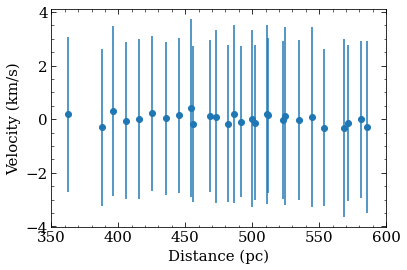

In [61]:
fig, ax = plt.subplots()
ax.scatter(dist_xx_sl, velo_yy_sl)
ax.errorbar(dist_xx_sl, velo_yy_sl, yerr = std_velo_sl, fmt = '.')
ax.set_xlabel('Distance (pc)')
ax.set_xlim(350, 600)
ax.set_ylabel('Velocity (km/s)')
plt.show()

0


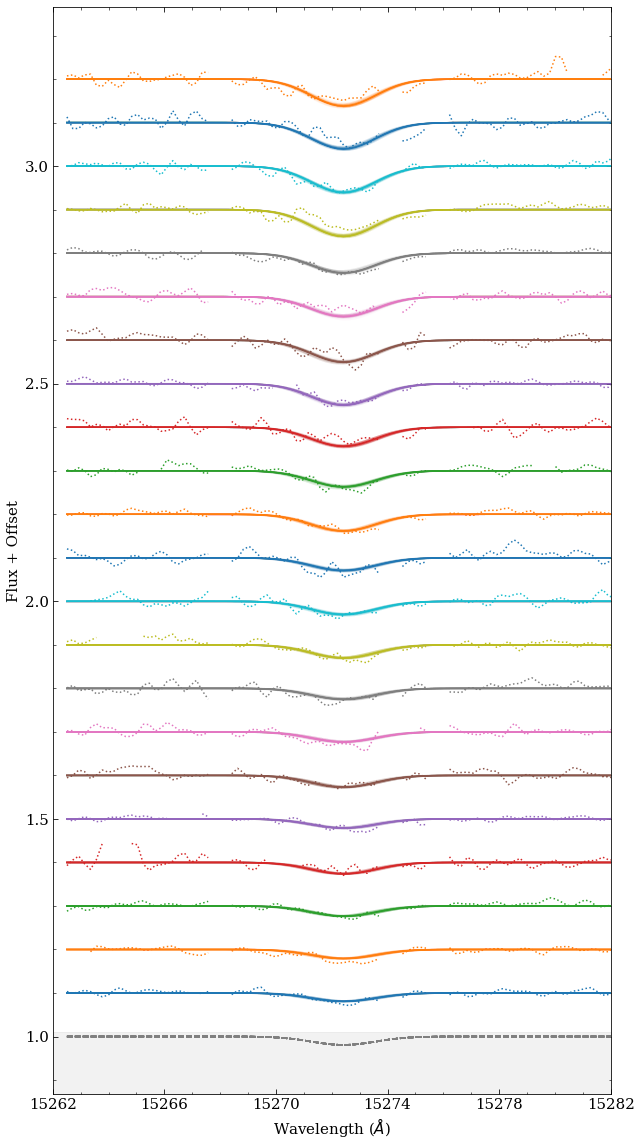

1


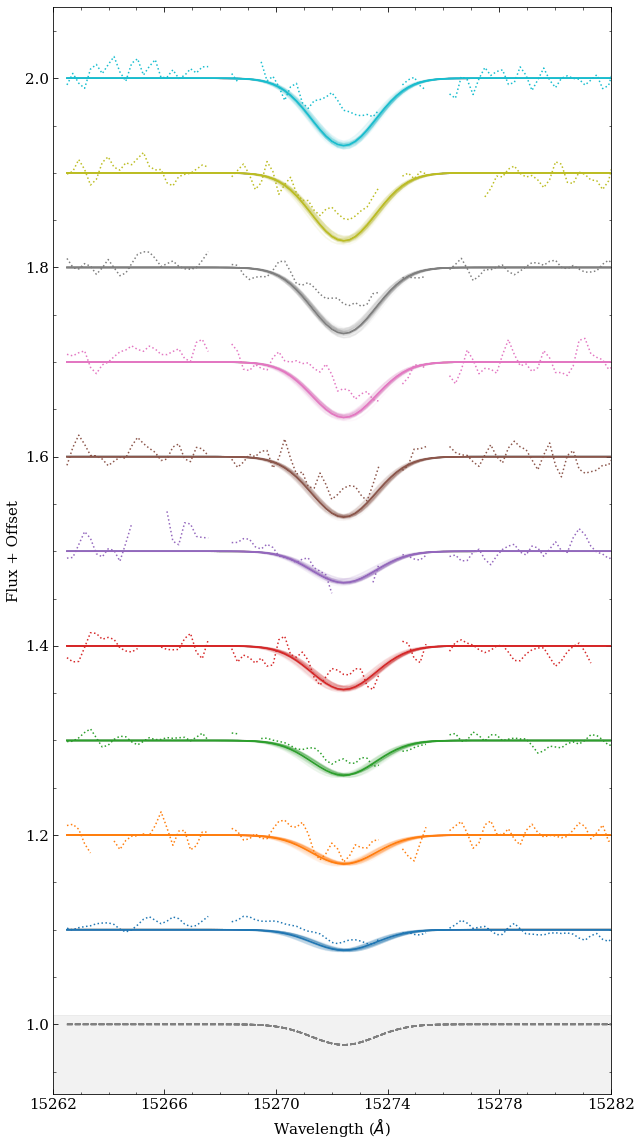

In [62]:
def model_signals_fg(rvelo, sl, dAVdd):
    # dAVdd = sl.dAVdd
    voxeldiffDIB = np.zeros((len(sl.stars), len(wavs_window)))
    unsummed_signals = np.zeros((len(sl.stars), len(sl.bins)-1,len(wavs_window)))
    # unsummed_signals = np.zeros((len(sl.bins)-1, len(sl.bins)-1,len(wavs_window)))

#     print(voxeldiffDIB.shape, unsummed_signals.shape, sl.dAVdd.shape)
    peak_wavelength = dopplershift(rvelo)
    wavs_grid = np.tile(wavs_window, (len(sl.bins) - 1, 1))
    voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
    amp = differentialAmplitude(dAVdd, sl.bins[1:]-sl.bins[:-1])

    def single_signal(amp, bindex):

        amp[bindex:] = 0 # THIS MIGHT NEED TO BE -1
        # print(amp)

        voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
        summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
        # continuum = lambda x, m, b : m * (x - lambda0) + b
        # cont = continuum(wavs_window, 0, b)
        return summed_DIB  + 1, voxel_DIB_scaled 

    fgdiffDIB = np.zeros((len(sl.stars), len(wavs_window)))
    

    for i in range(len(sl.stars)): # Iterate over each star in dAVdd array
#         print(dAVdd)
        dAVdd_bin = dAVdd[i, :] 

        amp = differentialAmplitude(dAVdd_bin, 1)

        bin_index = np.concatenate([sl.bin_inds]).astype(int)[i] # this only goes to 
        # signals[i, :] = single_signal(bin_index)
        voxeldiffDIB[i, :], unsummed_signals[i, :, :] = single_signal(amp, bin_index)
        fgdiffDIB[i, :], _ = single_signal(amp, 1)


    return voxeldiffDIB, unsummed_signals, fgdiffDIB


def make_plots_sample(samples, sl, logprob = None, chain = None):
    v = np.nanmedian(samples[:, :sl.ndim], axis = 0)
    davdd = np.nanmedian(samples[:, sl.ndim:], axis = 0).reshape(-1, sl.ndim)
    # av_offset = np.nanmedian(samples[:, 2*sl.ndim:], axis = 0)
    # davdd_all = np.ones((sl.nsig, sl.ndim)) * davdd + av_offset.reshape((sl.nsig, sl.ndim))

    if False: 
        best_step, best_walker = np.unravel_index(np.argmax(logprob), logprob.shape)
        davdd = chain[best_step, best_walker, sl.ndim:2*sl.ndim]
#         print(davdd.shape)
        davdd_all = davdd * np.ones((sl.nsig, sl.ndim)) + av_offset.reshape((sl.nsig, sl.ndim))

    def sample_signal():
        idx = (np.random.choice(samples.shape[0]))
        v = samples[idx, :sl.ndim]
        av = samples[idx, sl.ndim:].reshape(-1, sl.ndim)
        # av_scatter = samples[idx, 2*sl.ndim:]
        # davdd_all = av * np.ones((sl.nsig, sl.ndim)) + av_scatter.reshape((sl.nsig, sl.ndim))
        voxeldiffDIB, unsummed_signals, fgdiffDIB  = model_signals_fg(v, sl, av)
        return voxeldiffDIB, unsummed_signals, fgdiffDIB

    model_signals, signal_recreated_unsummed, fg_unsummed = model_signals_fg(v, sl, davdd)
#     print( model_signals.shape)

    fig, ax = plt.subplots(figsize = (10, 20))

    samp_signal = np.zeros((50, len(sl.stars), len(wavs_window)))
    samp_unsummed = np.zeros((50, len(sl.stars), len(sl.bins)-1, len(wavs_window)))
    samp_fgdiffDIB = np.zeros((50, len(sl.stars), len(wavs_window)))

    for idx in range(50):
        voxeldiffDIB, unsummed_signals, fgdiffDIB = sample_signal()
        samp_signal[idx, :, :] = voxeldiffDIB
        samp_unsummed[idx, :, :] = unsummed_signals
        samp_fgdiffDIB[idx, : :] = fgdiffDIB

    order_inds = np.array(np.argsort(sl.stars['DIST']))

    sep = 0.1
    offset = 0.1

    # signal_recreated, signal_recreated_unsummed = model_signals_thing(med_velo, sl, med_dAV_dd) 
    for i in range(len(order_inds)):
        ii = order_inds[i]
        # bindex = sl.bin_inds[ii]
        # ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * i, color = 'C{}'.format(i))
        # ax.fill_between(wavs_window, sl.signals[ii, :] + sl.signal_errs[ii, :] + 0.05 * i,
        #                  sl.signals[ii, :] - sl.signal_errs[ii, :] + 0.05 * i, color = 'C{}'.format(bindex), alpha = 0.1)


        ax.plot(wavs[window], model_signals[ii, :] + sep * i + offset, color = 'C{}'.format(i))        
        ax.plot(wavs[window], sl.signals[ii, :]+ sep * i + offset, linestyle = 'dotted', color = 'C{}'.format(i))
        for k in range(50):
            # samp, _, _ = sample_signal()
            ax.plot(wavs[window], samp_signal[k, ii, :] + sep * i + offset, alpha = 0.05, color ='C{}'.format(i))
        # for j in range(len(sl.bins)-1):
        #     if j==0:
        #         col = 'grey'
        #     else:
        #         col = 'C{}'.format(j-1)
        #     if j > i+1:
        #         continue
        #     ax.plot(wavs_window, unsummed_signals[ii, j, : ] + 1  + sep * i + offset, color=col, linestyle = 'dashed', alpha = 1)
        


        ax.set_xlabel('Wavelength ($\AA$)')
        ax.set_ylabel('Flux + Offset')
        ax.plot(wavs[window], fg_unsummed[0, :]  -sep + offset, linestyle = 'dashed', color ='grey',)
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(15272-10, 15272 + 10)
    ax.fill_between([15272-10, 15272+10], [1 + 0.1 * sep, 1 + 0.1 * sep], [ymin, ymin], color = 'grey', alpha = 0.1)
        
    ax.set_xticks(np.arange(15272-10, 15272+14, 4))
    return fig, ax        



for i in range(len(sightlines)):
    print(i)
    samples = chains[i].swapaxes(0,1)[-100:, :, :].reshape(-1, chains[i].shape[-1])

    fig, ax = make_plots_sample(samples, sightlines[i])
#     fig.savefig('RUNS_H5/figures_0602a/0602a_DIBmodels/model_realizations_sl{}.png'.format(name_i))

    plt.show()